<img style="float: left; margin: 30px 15px 15px 15px;" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTFzQj91sOlkeDFkg5HDbjtR4QJYmLXkfMNig&usqp=CAU" width="400" height="500" />
    
    
### <font color='navy'> Modelos no lineales para pronósticos.

**Nombres:** Axel Cabrera Jaramillo, Ricardo Damián Hernández Ramírez

**Fecha:** 13 feb 2024

**Expediente** : 730793, 740356
    
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**:[Link con el enlace del repositorio del creador del proyecto](https://github.com/jaramillooo/T3_AECabrera.git)

# Tarea 3

# <font color= Red>

Condensar todos los procedimientos realizados en esta clase donde se implementen los métodos necesarios para crear un correcto flujo de lectura de datos, análisis, ajuste de parámetros, predicción y métricas de errores para un conjunto de datos dado. Algo como lo siguiente:

```python
class LinearForecast:
    def __init__(self, atributos_del_contructor):
        
    def adf_test(self):
        
    def plot_acf_pac(self):
        
        .
        .
        .
````

Implementar los métodos y las lógicas que consideren pertinentes, como de igual forma las posibles variables a introducir en el constructor de la clase.

Posteriormente, utilizar la clase anteriormente creada para generar un modelo SARIMAX para el siguiente conjunto de datos:
https://github.com/quaesito/time-series-forecast-sarimax-prophet/blob/master/A4.xlsx?raw=true

Código de solución estudiante 1

In [31]:
import pandas as pd
from datetime import timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt 
from statsmodels.tsa.seasonal import MSTL
import itertools
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")


In [5]:


data = pd.read_excel(
                     "/Users/axeljaramillo/Documents/series_no_lineales/A4.xlsx")
                     #,index_col="Unnamed: 0")

#data["datetime"] = data[["year", "month", "day", "hour"]].apply(
#    lambda row: f"{row.year}-{row.month}-{row.day} {row.hour}:00:00", axis=1)

In [6]:
data

,Unnamed: 0,date,year,month,day,hour,GHI (W/m2),DNI (W/m2),DHI (W/m2),Wet bulb temp (C),Dew point temp (C),Energy (kWh)
0,6,1990-01-01,1990,Jan,Mon,6,234,503,78,12.1406,9.7,498.632
1,7,1990-01-01,1990,Jan,Mon,7,448,723,91,13.3250,10.1,720.409
2,8,1990-01-01,1990,Jan,Mon,8,699,959,71,13.3094,9.3,946.154
3,9,1990-01-01,1990,Jan,Mon,9,880,1016,73,13.9375,9.1,987.273
4,10,1990-01-01,1990,Jan,Mon,10,1009,1031,85,14.1141,8.0,1000.230
...,...,...,...,...,...,...,...,...,...,...,...,...
96995,8750,2014-12-31,2014,Dec,Wed,14,903,971,94,14.4875,8.8,925.713
96996,8751,2014-12-31,2014,Dec,Wed,15,746,950,76,14.2563,8.8,920.625
96997,8752,2014-12-31,2014,Dec,Wed,16,545,865,69,13.2500,8.6,854.471
96998,8753,2014-12-31,2014,Dec,Wed,17,308,599,80,13.0094,9.0,605.375


In [7]:
data = data[['date', 'Energy (kWh)']]
data.columns = ['date', 'y']
data = data.set_index('date').resample('M').mean()

In [27]:

class LinearForecast:
    def __init__(self, data): 
        self.data = data
        
    def plot_acf_pacf(self, kwargs=dict()):
        f = plt.figure(figsize=(8,5))
        ax1 = f.add_subplot(121)
        plot_acf(self.data, zero=False, ax=ax1, **kwargs)
        ax2 = f.add_subplot(122)
        plot_pacf(self.data, zero=False, ax=ax2, method='ols', **kwargs)
        plt.show()
        
    def adf_test(self, data):
        print("Results of Dickey-Fuller Test:")
        dftest = adfuller(data, autolag="AIC")
        dfoutput = pd.Series(
            dftest[0:4],
            index=[
                "Test Statistic",
                "p-value",
                "#Lags Used",
                "Number of Observations Used",
            ],
        )
        for key, value in dftest[4].items():
            dfoutput["Critical Value (%s)" % key] = value
        print(dfoutput)
        
        if (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0]):
            print("\u001b[32mStationary\u001b[0m")
        else:
            print("\x1b[31mNon-stationary\x1b[0m")
    
            
    def plot_seasonal_decomposition(self, periods_seasonality=(12, 24), stl_kwargs=None):
        if stl_kwargs is None:
            stl_kwargs = {"seasonal_deg": 0} 
        
        model = MSTL(self.data, periods=periods_seasonality, stl_kwargs=stl_kwargs)
        res = model.fit()

        fig, ax = plt.subplots(5, 1, sharex=True, figsize=(8, 8))

        res.observed.plot(ax=ax[0])
        ax[0].set_ylabel('Observed')

        res.trend.plot(ax=ax[1])
        ax[1].set_ylabel('Trend')

        res.seasonal[f'seasonal_{periods_seasonality[0]}'].plot(ax=ax[2])
        ax[2].set_ylabel(f'seasonal_{periods_seasonality[0]}')

        res.seasonal[f'seasonal_{periods_seasonality[1]}'].plot(ax=ax[3])
        ax[3].set_ylabel(f'seasonal_{periods_seasonality[1]}')

        res.resid.plot(ax=ax[4])
        ax[4].set_ylabel('Residual')

        fig.tight_layout()
        plt.show()
        return res

    def sarimax(self, p, d, q, P, D, Q, chosenSeasonality, t=['n', 'c', 't', 'ct']):

        params_no_estacionales = list(itertools.product(p, d, q))
        params_estacionales = [(x[0], x[1], x[2], chosenSeasonality) for x in list(itertools.product(P, D, Q))]

        sarimax_params = list(itertools.product(params_no_estacionales, params_estacionales, t))
        self.sarimax_params = sarimax_params

    def best_params(self):

        resultados = pd.DataFrame(columns=['params', 'AIC', 'BIC', 'LLF'], index=np.arange(0, 11))

        print(f'{len(self.sarimax_params)} combinations')

        i = 0
        for par_no_season, par_season, trend in self.sarimax_params:

            mod = SARIMAX(
                endog=self.data,
                trend=trend,
                order=par_no_season,
                seasonal_order=par_season
            )
            results = mod.fit()

            print(f'Params: {par_no_season}, {par_season}, {trend}')

            resultados.loc[i, 'params'] = str((par_no_season, par_season, trend))
            resultados.loc[i, 'AIC'] = results.aic
            resultados.loc[i, 'BIC'] = results.bic
            resultados.loc[i, 'LLF'] = results.llf
            i += 1

        self.resultadosParams = resultados
        return self.resultadosParams
    def sarimax_model(self, order, seasonal_order):
        model = SARIMAX(self.data, order=order, seasonal_order=seasonal_order)
        return model

In [19]:
lf = LinearForecast(data)
lf.adf_test(data)


Results of Dickey-Fuller Test:
Test Statistic                  -2.242267
p-value                          0.191264
#Lags Used                      13.000000
Number of Observations Used    286.000000
Critical Value (1%)             -3.453423
Critical Value (5%)             -2.871699
Critical Value (10%)            -2.572183
dtype: float64
Non-stationary


In [20]:
lf.adf_test(data.diff(1).dropna())

Results of Dickey-Fuller Test:
Test Statistic                -1.185352e+01
p-value                        7.115964e-22
#Lags Used                     1.200000e+01
Number of Observations Used    2.860000e+02
Critical Value (1%)           -3.453423e+00
Critical Value (5%)           -2.871699e+00
Critical Value (10%)          -2.572183e+00
dtype: float64
Stationary


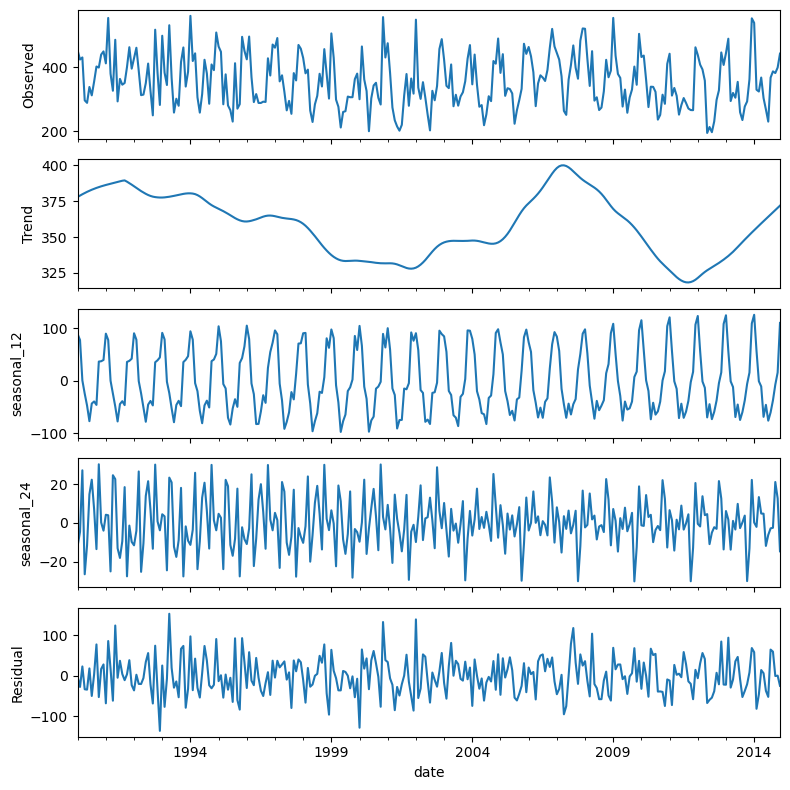

In [37]:
desco = lf.plot_seasonal_decomposition()

In [32]:
p = [0, 1, 2]
d = [1]
q = [0, 1]
P = [0, 1]
D = [0]
Q = [0, 1]
ls = LinearForecast(data)
ls.sarimax(p, d, q, P, D, Q, 6)
posibleParams = ls.best_params().sort_values(by=['AIC'], ascending=True)
posibleParams

96 combinations
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.83587D+00    |proj g|=  3.95244D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      3      1     0     0   8.438D-09   5.836D+00
  F =   5.8358657326038266     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Params: (0, 1, 0), (0, 0, 0, 6), n
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables ar

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      7      1     0     0   9.410D-06   5.835D+00
  F =   5.8354576756121768     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Params: (0, 1, 0), (0, 0, 1, 6), t
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.83940D+00    |proj g|=  1.00090D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy sear

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


Params: (0, 1, 0), (1, 0, 0, 6), ct
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.84076D+00    |proj g|=  1.19455D-01

At iterate    5    f=  5.83439D+00    |proj g|=  2.38626D-02

At iterate   10    f=  5.82496D+00    |proj g|=  4.30212D-02

At iterate   15    f=  5.80455D+00    |proj g|=  5.07966D-03

At iterate   20    f=  5.79998D+00    |proj g|=  1.64207D-04

At iterate   25    f=  5.79932D+00    |proj g|=  2.43040D-04

At iterate   30    f=  5.79922D+00    |proj g|=  7.70064D-05

At iterate   35    f=  5.79920D+00    |proj g|=  3.07027D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projec

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  5.80469D+00    |proj g|=  5.05192D-03

At iterate   20    f=  5.80010D+00    |proj g|=  2.08326D-04

At iterate   25    f=  5.79939D+00    |proj g|=  2.41314D-04

At iterate   30    f=  5.79923D+00    |proj g|=  9.98273D-05

At iterate   35    f=  5.79920D+00    |proj g|=  4.33808D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     40      1     0     0   5.451D-06   5.799D+00
  F =   5.7991922516880443     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Params: (0, 1, 0), (1, 0, 1, 6), c
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N 

 This problem is unconstrained.



At iterate    5    f=  5.83442D+00    |proj g|=  1.48307D-02

At iterate   10    f=  5.82597D+00    |proj g|=  4.63019D-02

At iterate   15    f=  5.80624D+00    |proj g|=  8.68828D-03

At iterate   20    f=  5.80160D+00    |proj g|=  4.19928D-03

At iterate   25    f=  5.79949D+00    |proj g|=  1.03034D-02

At iterate   30    f=  5.79926D+00    |proj g|=  2.95478D-04

At iterate   35    f=  5.79920D+00    |proj g|=  7.06384D-04

At iterate   40    f=  5.79919D+00    |proj g|=  4.54427D-04

At iterate   45    f=  5.79918D+00    |proj g|=  1.54946D-04

At iterate   50    f=  5.79918D+00    |proj g|=  1.82915D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.79714D+00    |proj g|=  2.39702D-01

At iterate    5    f=  5.76896D+00    |proj g|=  2.95021D-03

At iterate   10    f=  5.76326D+00    |proj g|=  1.04417D-01

At iterate   15    f=  5.75071D+00    |proj g|=  1.11909D-02

At iterate   20    f=  5.74924D+00    |proj g|=  3.87768D-03

At iterate   25    f=  5.74916D+00    |proj g|=  1.95195D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     35      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  5.75005D+00    |proj g|=  1.81046D-03

At iterate   25    f=  5.74942D+00    |proj g|=  1.27861D-02

At iterate   30    f=  5.74880D+00    |proj g|=  2.43394D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     38      1     0     0   3.058D-06   5.749D+00
  F =   5.7488000643961614     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Params: (0, 1, 1), (0, 0, 1, 6), c
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.79711D+00

 This problem is unconstrained.



At iterate   20    f=  5.75054D+00    |proj g|=  1.59335D-01

At iterate   25    f=  5.74974D+00    |proj g|=  2.66657D-01

At iterate   30    f=  5.74948D+00    |proj g|=  1.91506D-02

At iterate   35    f=  5.74907D+00    |proj g|=  4.52569D-01

At iterate   40    f=  5.74820D+00    |proj g|=  6.75709D-03

At iterate   45    f=  5.74820D+00    |proj g|=  1.61438D-02

At iterate   50    f=  5.74820D+00    |proj g|=  7.34534D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     66      1     0     0   7.345D-05   5.748D+00
  F =   5.7481961100029411     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  5.70308D+00    |proj g|=  1.15054D-02

At iterate   20    f=  5.70124D+00    |proj g|=  3.35465D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     24      1     0     0   3.355D-07   5.701D+00
  F =   5.7012419588101713     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Params: (0, 1, 1), (1, 0, 0, 6), n
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.78172D+00    |proj g|=  1.26778D-01

At iterate    5    f=  5.72031D+00

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  5.70971D+00    |proj g|=  5.07427D-02

At iterate   15    f=  5.70951D+00    |proj g|=  1.42252D-01

At iterate   20    f=  5.70125D+00    |proj g|=  1.11055D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     31      1     0     0   1.448D-03   5.701D+00
  F =   5.7012218933804144     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Params: (0, 1, 1), (1, 0, 0, 6), t
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.78163D+00

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.63121D+00    |proj g|=  4.98128D-02

At iterate   10    f=  5.61623D+00    |proj g|=  1.96614D-02

At iterate   15    f=  5.53445D+00    |proj g|=  1.71409D-02

At iterate   20    f=  5.52988D+00    |proj g|=  6.68149D-04

At iterate   25    f=  5.52741D+00    |proj g|=  1.04651D-03

At iterate   30    f=  5.52682D+00    |proj g|=  2.58385D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     40      1     0     0   7.803D-06   5.527D+00
  F =   5.5267882133202129     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Params: (0, 1, 1), (1, 0, 1, 6), n
RUNNING THE L-BF

 This problem is unconstrained.



At iterate   20    f=  5.61306D+00    |proj g|=  5.94195D-02

At iterate   25    f=  5.61035D+00    |proj g|=  2.28640D-01

At iterate   30    f=  5.61017D+00    |proj g|=  1.19489D-02

At iterate   35    f=  5.60427D+00    |proj g|=  8.26420D-01

At iterate   40    f=  5.59791D+00    |proj g|=  7.35234D-01

At iterate   45    f=  5.55967D+00    |proj g|=  6.95265D-01

At iterate   50    f=  5.54989D+00    |proj g|=  5.99781D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     80      1     0     0   5.998D-02   5.550D+00
  F =   5.5498912878389968     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   15    f=  5.62524D+00    |proj g|=  1.74203D+00

At iterate   20    f=  5.60816D+00    |proj g|=  8.56643D-02

At iterate   25    f=  5.60652D+00    |proj g|=  1.26931D-01

At iterate   30    f=  5.60542D+00    |proj g|=  1.63704D-01

At iterate   35    f=  5.60258D+00    |proj g|=  8.06956D-02

At iterate   40    f=  5.59362D+00    |proj g|=  3.27537D-01

At iterate   45    f=  5.54209D+00    |proj g|=  5.19344D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     78      1     0     0   1.355D-01   5.542D+00
  F =   5.5417657862578729     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      6      1     0     0   3.645D-05   5.797D+00
  F =   5.7967375834933588     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Params: (1, 1, 0), (0, 0, 0, 6), t
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.79665D+00    |proj g|=  7.72656D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy sear

 This problem is unconstrained.
 This problem is unconstrained.


Params: (1, 1, 0), (0, 0, 1, 6), c
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.80531D+00    |proj g|=  1.94386D-01

At iterate    5    f=  5.79139D+00    |proj g|=  1.70622D-04

At iterate   10    f=  5.79138D+00    |proj g|=  1.68951D-03

At iterate   15    f=  5.79135D+00    |proj g|=  6.70777D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     22      1     0     0   1.601D-05   5.791D+00
  F =   5.7913379202416957     

CONVERGENCE: REL_REDUCTION_OF_F_<=

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  5.79127D+00    |proj g|=  5.99412D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     22      1     0     0   8.093D-06   5.791D+00
  F =   5.7912555639090320     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Params: (1, 1, 0), (0, 0, 1, 6), ct
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.79356D+00    |proj g|=  8.55815D-02

At iterate    5    f=  5.78919D+00    |proj g|=  2.32417D-04

At iterate   10    f=  5.78916D+0

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.78917D+00    |proj g|=  2.27253D-04

At iterate   10    f=  5.78916D+00    |proj g|=  6.75075D-03

At iterate   15    f=  5.78909D+00    |proj g|=  2.32259D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     20      1     0     0   9.568D-06   5.789D+00
  F =   5.7890874245034922     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Params: (1, 1, 0), (1, 0, 0, 6), t
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.79345D+00

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.80717D+00    |proj g|=  2.21452D-01

At iterate    5    f=  5.78432D+00    |proj g|=  3.21222D-02

At iterate   10    f=  5.73722D+00    |proj g|=  1.09410D-02

At iterate   15    f=  5.72240D+00    |proj g|=  3.14708D-02

At iterate   20    f=  5.71067D+00    |proj g|=  1.41709D-03

At iterate   25    f=  5.71045D+00    |proj g|=  1.52592D-04

At iterate   30    f=  5.71040D+00    |proj g|=  2.05876D-03

At iterate   35    f=  5.71038D+00    |proj g|=  8.71544D-05

At iterate   40    f=  5.71037D+00    |proj g|=  5.16948D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate   40    f=  5.71037D+00    |proj g|=  8.47793D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     48      1     0     0   8.478D-06   5.710D+00
  F =   5.7103694932979696     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Params: (1, 1, 0), (1, 0, 1, 6), c
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.80715D+00    |proj g|=  2.21415D-01

At iterate    5    f=  5.78552D+00    |proj g|=  2.17917D-02

At iterate   10    f=  5.73096D+00

 This problem is unconstrained.



At iterate   35    f=  5.71043D+00    |proj g|=  6.43255D-03

At iterate   40    f=  5.71040D+00    |proj g|=  8.73319D-04

At iterate   45    f=  5.71038D+00    |proj g|=  5.40248D-04

At iterate   50    f=  5.71037D+00    |proj g|=  3.10722D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     55      1     0     0   3.107D-04   5.710D+00
  F =   5.7103683604865516     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Params: (1, 1, 0), (1, 0, 1, 6), t
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  5.71704D+00    |proj g|=  1.68010D-02

At iterate   25    f=  5.71044D+00    |proj g|=  1.89068D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     31      1     0     0   1.099D-05   5.710D+00
  F =   5.7103892762377289     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Params: (1, 1, 0), (1, 0, 1, 6), ct
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.78378D+00    |proj g|=  3.40387D-02

At iterate    5    f=  5.76988D+0

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  5.69642D+00    |proj g|=  3.89799D-02

At iterate   20    f=  5.68929D+00    |proj g|=  3.04057D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     26      1     0     0   1.728D-06   5.689D+00
  F =   5.6892887212453465     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Params: (1, 1, 1), (0, 0, 0, 6), c
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.78376D+00    |proj g|=  3.39753D-02

At iterate    5    f=  5.76621D+00


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f=  5.68799D+00    |proj g|=  1.13468D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     45     70      1     0     0   1.135D-02   5.688D+00
  F =   5.6879919755586084     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Params: (1, 1, 1), (0, 0, 0, 6), ct
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.79509D+00    |proj g|=  2.46601D-01

At iterate    5    f=  5.73235D+00    |proj g|=  2.10784D-01

At iterate   10    f=  5.69500D+0

 This problem is unconstrained.



At iterate   20    f=  5.69400D+00    |proj g|=  3.27473D-01

At iterate   25    f=  5.69366D+00    |proj g|=  2.90731D-01

At iterate   30    f=  5.68651D+00    |proj g|=  1.81202D+01

At iterate   35    f=  5.68153D+00    |proj g|=  1.89586D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     65      1     0     0   6.470D-03   5.682D+00
  F =   5.6815165346053620     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Params: (1, 1, 1), (0, 0, 1, 6), t



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.79502D+00    |proj g|=  2.46497D-01

At iterate    5    f=  5.76707D+00    |proj g|=  2.73784D-02

At iterate   10    f=  5.72326D+00    |proj g|=  5.27495D-01

At iterate   15    f=  5.69625D+00    |proj g|=  5.87065D-02

At iterate   20    f=  5.69323D+00    |proj g|=  3.39259D-01

At iterate   25    f=  5.69259D+00    |proj g|=  3.60564D-01

At iterate   30    f=  5.69193D+00    |proj g|=  1.93136D+00

At iterate   35    f=  5.68955D+00    |proj g|=  1.44929D-01

At iterate   40    f=  5.68944D+00    |proj g|=  9.17941D-01

At iterate   45    f=  5.68387D+00    |proj g|=  4.26196D+00

At iterate   50    f=  5.67847D+00    |proj g|=  9.96372D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.71546D+00    |proj g|=  8.11433D-02

At iterate   10    f=  5.68809D+00    |proj g|=  2.55433D-03

At iterate   15    f=  5.68497D+00    |proj g|=  1.48209D-02

At iterate   20    f=  5.67845D+00    |proj g|=  1.69853D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     29      1     0     0   4.489D-05   5.678D+00
  F =   5.6784420418769708     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Params: (1, 1, 1), (1, 0, 0, 6), n
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables

 This problem is unconstrained.



At iterate   35    f=  5.68464D+00    |proj g|=  4.68257D-01

At iterate   40    f=  5.67532D+00    |proj g|=  8.62857D-03

At iterate   45    f=  5.67522D+00    |proj g|=  3.40042D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     47     57      1     0     0   6.789D-03   5.675D+00
  F =   5.6752162443291745     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Params: (1, 1, 1), (1, 0, 0, 6), t
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.77901D+00

 This problem is unconstrained.



At iterate   15    f=  5.68790D+00    |proj g|=  1.25288D-01

At iterate   20    f=  5.68692D+00    |proj g|=  2.10053D-01

At iterate   25    f=  5.68662D+00    |proj g|=  2.50199D-01

At iterate   30    f=  5.68608D+00    |proj g|=  1.00057D+00

At iterate   35    f=  5.67319D+00    |proj g|=  1.88831D+00

At iterate   40    f=  5.67252D+00    |proj g|=  1.64051D-02

At iterate   45    f=  5.67251D+00    |proj g|=  2.80558D-01

At iterate   50    f=  5.67217D+00    |proj g|=  1.51293D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     57      1     0     0   1.513D+00   5.672D+00
  F =   5.67216587160

 This problem is unconstrained.



At iterate   35    f=  5.54464D+00    |proj g|=  4.00476D-04

At iterate   40    f=  5.54459D+00    |proj g|=  1.31877D-03

At iterate   45    f=  5.54457D+00    |proj g|=  3.21929D-04

At iterate   50    f=  5.54456D+00    |proj g|=  7.73728D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     61      1     0     0   7.737D-06   5.545D+00
  F =   5.5445605059417495     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Params: (1, 1, 1), (1, 0, 1, 6), n
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables

 This problem is unconstrained.



At iterate   10    f=  5.60949D+00    |proj g|=  1.61509D-02

At iterate   15    f=  5.58501D+00    |proj g|=  4.55115D-02

At iterate   20    f=  5.53692D+00    |proj g|=  2.15949D-02

At iterate   25    f=  5.53635D+00    |proj g|=  4.59998D-05

At iterate   30    f=  5.53634D+00    |proj g|=  2.13942D-03

At iterate   35    f=  5.53617D+00    |proj g|=  6.21002D-03

At iterate   40    f=  5.53611D+00    |proj g|=  9.03643D-04

At iterate   45    f=  5.53601D+00    |proj g|=  1.64226D-03

At iterate   50    f=  5.53599D+00    |proj g|=  8.41190D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     54   

 This problem is unconstrained.



At iterate   20    f=  5.60532D+00    |proj g|=  1.22690D-01

At iterate   25    f=  5.60482D+00    |proj g|=  3.17779D-01

At iterate   30    f=  5.59952D+00    |proj g|=  2.27618D-01

At iterate   35    f=  5.56711D+00    |proj g|=  1.69192D-01

At iterate   40    f=  5.54114D+00    |proj g|=  2.28706D+00

At iterate   45    f=  5.53890D+00    |proj g|=  2.25082D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45     53      1     0     0   2.251D-03   5.539D+00
  F =   5.5388950741310978     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Params: (1, 1, 1), (1, 0, 1, 6), t
RUNNING THE L-BF

 This problem is unconstrained.



At iterate   25    f=  5.60162D+00    |proj g|=  2.54510D-01

At iterate   30    f=  5.59984D+00    |proj g|=  1.03260D+00

At iterate   35    f=  5.59733D+00    |proj g|=  3.73339D-01

At iterate   40    f=  5.59682D+00    |proj g|=  1.07689D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f=  5.59394D+00    |proj g|=  9.99709D-01

At iterate   50    f=  5.59387D+00    |proj g|=  2.78180D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     84      2     0     0   2.782D-02   5.594D+00
  F =   5.5938676558684692     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Params: (1, 1, 1), (1, 0, 1, 6), ct
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.78373D+00    |proj g|=  1.00311D-03

           * * *

Tit   = total n

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.78360D+00    |proj g|=  1.02739D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      4      6      1     0     0   7.876D-05   5.784D+00
  F =   5.7835954463639716     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Params: (2, 1, 0), (0, 0, 0, 6), ct
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at th

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.76956D+00    |proj g|=  4.07567D-03

At iterate   10    f=  5.76954D+00    |proj g|=  1.64830D-03

At iterate   15    f=  5.76940D+00    |proj g|=  1.78628D-02

At iterate   20    f=  5.76923D+00    |proj g|=  2.01027D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     26      1     0     0   8.569D-06   5.769D+00
  F =   5.7692277259056919     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Params: (2, 1, 0), (0, 0, 1, 6), ct
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variable

 This problem is unconstrained.
 This problem is unconstrained.


Params: (2, 1, 0), (1, 0, 0, 6), n
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.77848D+00    |proj g|=  1.50272D-01

At iterate    5    f=  5.75985D+00    |proj g|=  6.94613D-04

At iterate   10    f=  5.75964D+00    |proj g|=  1.30179D-02

At iterate   15    f=  5.75903D+00    |proj g|=  3.40854D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     19      1     0     0   8.303D-05   5.759D+00
  F =   5.7590322340346294     

CONVERGENCE: REL_REDUCTION_OF_F_<=

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  5.75980D+00    |proj g|=  6.75341D-03

At iterate   15    f=  5.75919D+00    |proj g|=  3.30121D-02

At iterate   20    f=  5.75902D+00    |proj g|=  1.61173D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     24      1     0     0   8.800D-06   5.759D+00
  F =   5.7590173730319005     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Params: (2, 1, 0), (1, 0, 0, 6), t
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.77835D+00

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  5.63076D+00    |proj g|=  3.81506D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     31      1     0     0   5.069D-05   5.631D+00
  F =   5.6307554725932727     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Params: (2, 1, 0), (1, 0, 1, 6), n
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.79844D+00    |proj g|=  3.00247D-01

At iterate    5    f=  5.73802D+00    |proj g|=  7.66114D-02

At iterate   10    f=  5.67163D+00

 This problem is unconstrained.



At iterate   15    f=  5.66419D+00    |proj g|=  5.76775D-02

At iterate   20    f=  5.65300D+00    |proj g|=  1.70886D-02

At iterate   25    f=  5.63575D+00    |proj g|=  1.21531D-02

At iterate   30    f=  5.63072D+00    |proj g|=  1.17616D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     36      1     0     0   3.367D-06   5.631D+00
  F =   5.6307232003990633     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Params: (2, 1, 0), (1, 0, 1, 6), t
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables

 This problem is unconstrained.



At iterate    5    f=  5.75228D+00    |proj g|=  5.68471D-02

At iterate   10    f=  5.68339D+00    |proj g|=  1.08857D-01

At iterate   15    f=  5.66603D+00    |proj g|=  9.89631D-02

At iterate   20    f=  5.65243D+00    |proj g|=  3.21044D-02

At iterate   25    f=  5.63596D+00    |proj g|=  6.96040D-03

At iterate   30    f=  5.63072D+00    |proj g|=  9.75637D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     34     38      1     0     0   1.046D-05   5.631D+00
  F =   5.6307137743990250     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Params: (2, 1, 0), (1, 0, 1, 6), ct
RUNNING THE L-B

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     34      1     0     0   1.581D-05   5.783D+00
  F =   5.7830694949297934     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Params: (2, 1, 1), (0, 0, 0, 6), c
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.78312D+00    |proj g|=  2.60945D-03

At iterate    5    f=  5.78310D+00    |proj g|=  3.63146D-03

At iterate   10    f=  5.78305D+00    |proj g|=  1.54612D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

     

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.76937D+00    |proj g|=  3.83272D-04

At iterate   10    f=  5.76935D+00    |proj g|=  1.63903D-03

At iterate   15    f=  5.76914D+00    |proj g|=  4.38078D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     21      1     0     0   3.841D-06   5.769D+00
  F =   5.7691229988945238     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Params: (2, 1, 1), (0, 0, 1, 6), n
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.79541D+00

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  5.76913D+00    |proj g|=  4.29341D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     22      1     0     0   4.293D-05   5.769D+00
  F =   5.7691270839409770     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Params: (2, 1, 1), (0, 0, 1, 6), c
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.79537D+00    |proj g|=  2.64280D-01

At iterate    5    f=  5.76935D+00    |proj g|=  2.94377D-03

At iterate   10    f=  5.76934D+00

 This problem is unconstrained.



At iterate   25    f=  5.76905D+00    |proj g|=  7.49167D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     25     28      1     0     0   7.492D-05   5.769D+00
  F =   5.7690516004533663     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Params: (2, 1, 1), (0, 0, 1, 6), ct
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.77792D+00    |proj g|=  1.49543D-01

At iterate    5    f=  5.76024D+00    |proj g|=  4.34697D-03

At iterate   10    f=  5.73644D+0

 This problem is unconstrained.



At iterate   30    f=  5.67763D+00    |proj g|=  8.74563D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     38      1     0     0   8.746D-06   5.678D+00
  F =   5.6776298560902330     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Params: (2, 1, 1), (1, 0, 0, 6), n
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.77793D+00    |proj g|=  1.49531D-01

At iterate    5    f=  5.76027D+00    |proj g|=  4.32732D-03

At iterate   10    f=  5.73674D+00

 This problem is unconstrained.



At iterate   20    f=  5.68482D+00    |proj g|=  4.83372D-03

At iterate   25    f=  5.67928D+00    |proj g|=  4.29979D-02

At iterate   30    f=  5.67348D+00    |proj g|=  2.16868D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     41      1     0     0   6.457D-06   5.673D+00
  F =   5.6734820090607956     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Params: (2, 1, 1), (1, 0, 0, 6), c
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.77789D+00

 This problem is unconstrained.



At iterate   10    f=  5.74949D+00    |proj g|=  1.28196D-01

At iterate   15    f=  5.71877D+00    |proj g|=  7.53358D-01

At iterate   20    f=  5.69441D+00    |proj g|=  1.76048D-01

At iterate   25    f=  5.68639D+00    |proj g|=  2.63325D-01

At iterate   30    f=  5.68582D+00    |proj g|=  1.27230D-01

At iterate   35    f=  5.68567D+00    |proj g|=  4.37321D-01

At iterate   40    f=  5.67780D+00    |proj g|=  2.91087D+00

At iterate   45    f=  5.67606D+00    |proj g|=  1.91763D+00

At iterate   50    f=  5.67503D+00    |proj g|=  1.93767D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     60   

 This problem is unconstrained.



At iterate   10    f=  5.74944D+00    |proj g|=  1.27901D-01

At iterate   15    f=  5.72256D+00    |proj g|=  5.97224D-01

At iterate   20    f=  5.69361D+00    |proj g|=  8.70582D-01

At iterate   25    f=  5.68501D+00    |proj g|=  7.22588D-02

At iterate   30    f=  5.68331D+00    |proj g|=  6.44702D-01

At iterate   35    f=  5.68278D+00    |proj g|=  8.42952D-02

At iterate   40    f=  5.68190D+00    |proj g|=  6.46796D-01

At iterate   45    f=  5.68081D+00    |proj g|=  3.18331D-02

At iterate   50    f=  5.68065D+00    |proj g|=  2.22103D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     61   

 This problem is unconstrained.



At iterate   20    f=  5.56880D+00    |proj g|=  2.98670D-02

At iterate   25    f=  5.54201D+00    |proj g|=  5.31752D-03

At iterate   30    f=  5.54142D+00    |proj g|=  1.22629D-02

At iterate   35    f=  5.52052D+00    |proj g|=  3.52361D-02

At iterate   40    f=  5.51965D+00    |proj g|=  1.20486D-04

At iterate   45    f=  5.51965D+00    |proj g|=  7.76877D-04

At iterate   50    f=  5.51957D+00    |proj g|=  8.15594D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     64      1     0     0   8.156D-03   5.520D+00
  F =   5.5195708227017315     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   15    f=  5.58987D+00    |proj g|=  1.10378D-02

At iterate   20    f=  5.57822D+00    |proj g|=  8.88581D-03

At iterate   25    f=  5.53017D+00    |proj g|=  1.20847D-02

At iterate   30    f=  5.51925D+00    |proj g|=  1.93139D-03

At iterate   35    f=  5.51922D+00    |proj g|=  2.99093D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     35     38      1     0     0   2.991D-05   5.519D+00
  F =   5.5192240466536910     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Params: (2, 1, 1), (1, 0, 1, 6), c
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N 

 This problem is unconstrained.



At iterate   25    f=  5.58795D+00    |proj g|=  4.79062D-02

At iterate   30    f=  5.58791D+00    |proj g|=  2.67564D-02

At iterate   35    f=  5.58750D+00    |proj g|=  6.85898D-02

At iterate   40    f=  5.57327D+00    |proj g|=  1.11727D-01

At iterate   45    f=  5.52025D+00    |proj g|=  7.02473D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     49     57      1     0     0   2.130D-03   5.520D+00
  F =   5.5201941658157887     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Params: (2, 1, 1), (1, 0, 1, 6), t
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N 

 This problem is unconstrained.



At iterate   20    f=  5.60069D+00    |proj g|=  9.07089D-02

At iterate   25    f=  5.58762D+00    |proj g|=  5.97767D-02

At iterate   30    f=  5.58757D+00    |proj g|=  3.52943D-02

At iterate   35    f=  5.58717D+00    |proj g|=  5.76517D-02

At iterate   40    f=  5.58553D+00    |proj g|=  1.21688D-01

At iterate   45    f=  5.56296D+00    |proj g|=  1.09586D+00

At iterate   50    f=  5.52960D+00    |proj g|=  2.67285D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     60      1     0     0   2.673D-01   5.530D+00
  F =   5.5296042303714552     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

,params,AIC,BIC,LLF
92,"((2, 1, 1), (1, 0, 1, 6), 'n')",3323.742494,3345.945155,-1655.871247
28,"((0, 1, 1), (1, 0, 1, 6), 'n')",3324.072928,3338.874702,-1658.036464
93,"((2, 1, 1), (1, 0, 1, 6), 'c')",3325.534428,3351.437533,-1655.767214
94,"((2, 1, 1), (1, 0, 1, 6), 't')",3326.116499,3352.019605,-1656.05825
61,"((1, 1, 1), (1, 0, 1, 6), 'c')",3333.592769,3355.795431,-1660.796385
...,...,...,...,...
6,"((0, 1, 0), (0, 0, 1, 6), 't')",3507.274605,3518.375936,-1750.637303
5,"((0, 1, 0), (0, 0, 1, 6), 'c')",3507.284056,3518.385387,-1750.642028
3,"((0, 1, 0), (0, 0, 0, 6), 'ct')",3507.474469,3518.575799,-1750.737234
11,"((0, 1, 0), (1, 0, 0, 6), 'ct')",3509.18336,3523.985134,-1750.59168


In [35]:
so = (1, 0, 1, 12)
o = (2, 2, 1)
forcast = LinearForecast(data)
model = forcast.sarimax_model(o, so)
results = model.fit()
print(results.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.79774D+00    |proj g|=  2.98063D-01

At iterate    5    f=  5.74817D+00    |proj g|=  5.14454D-02

At iterate   10    f=  5.61383D+00    |proj g|=  1.07684D-01

At iterate   15    f=  5.58894D+00    |proj g|=  1.08317D-02

At iterate   20    f=  5.56880D+00    |proj g|=  2.98670D-02

At iterate   25    f=  5.54201D+00    |proj g|=  5.31752D-03

At iterate   30    f=  5.54142D+00    |proj g|=  1.22629D-02


 This problem is unconstrained.



At iterate   35    f=  5.52052D+00    |proj g|=  3.52361D-02

At iterate   40    f=  5.51965D+00    |proj g|=  1.20486D-04

At iterate   45    f=  5.51965D+00    |proj g|=  7.76877D-04

At iterate   50    f=  5.51957D+00    |proj g|=  8.15594D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     64      1     0     0   8.156D-03   5.520D+00
  F =   5.5195708227017315     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 

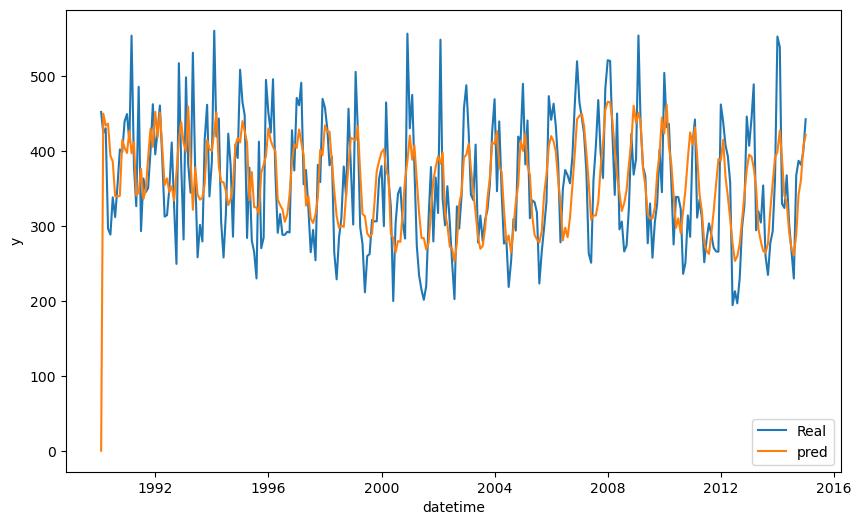

In [53]:
predictions = results.predict()
plt.figure(figsize=(10, 6))
plt.plot(data, label='Real')
plt.plot(predictions, label='pred', linestyle='-')
plt.xlabel('datetime')
plt.ylabel('y')
plt.legend()
plt.show()

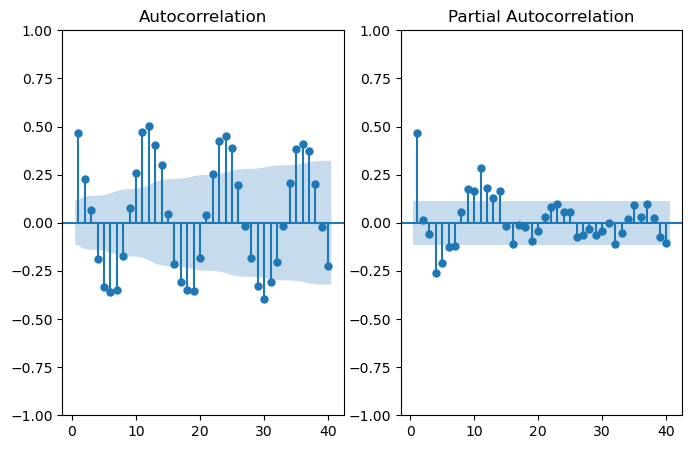

In [36]:
LinearForecast(data).plot_acf_pacf({'lags': 40})

<Axes: xlabel='date'>

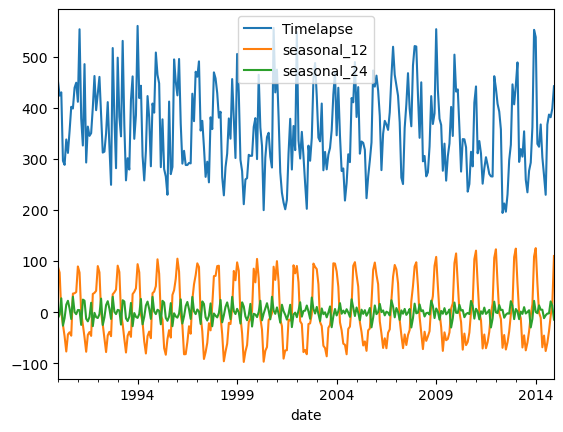

In [38]:
ax = desco.observed.to_frame('Timelapse').plot()
desco.seasonal.plot(ax=ax)

# Separando 

In [45]:
seasonality_24 = desco.seasonal['seasonal_24']
LinearForecast(seasonality_24.diff()).adf_test(data)

Results of Dickey-Fuller Test:
Test Statistic                  -2.242267
p-value                          0.191264
#Lags Used                      13.000000
Number of Observations Used    286.000000
Critical Value (1%)             -3.453423
Critical Value (5%)             -2.871699
Critical Value (10%)            -2.572183
dtype: float64
Non-stationary


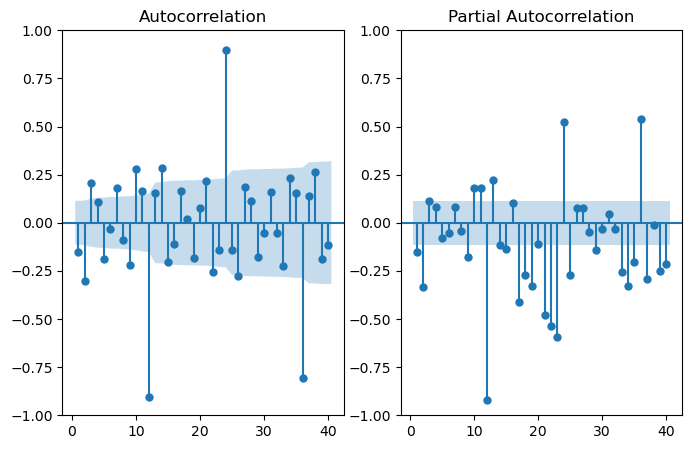

In [47]:
LinearForecast(seasonality_24).plot_acf_pacf({'lags': 40})

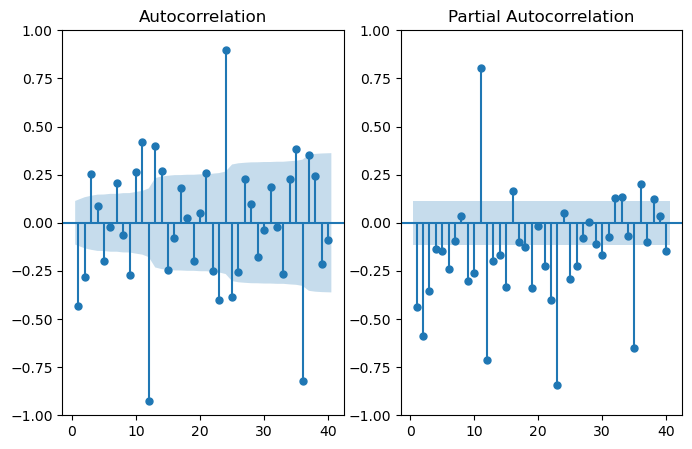

In [50]:
LinearForecast(seasonality_24.diff().dropna()).plot_acf_pacf({'lags': 40})

In [46]:
seasonality_12 = desco.seasonal['seasonal_12']
LinearForecast(seasonality_24.diff()).adf_test(data)

Results of Dickey-Fuller Test:
Test Statistic                  -2.242267
p-value                          0.191264
#Lags Used                      13.000000
Number of Observations Used    286.000000
Critical Value (1%)             -3.453423
Critical Value (5%)             -2.871699
Critical Value (10%)            -2.572183
dtype: float64
Non-stationary


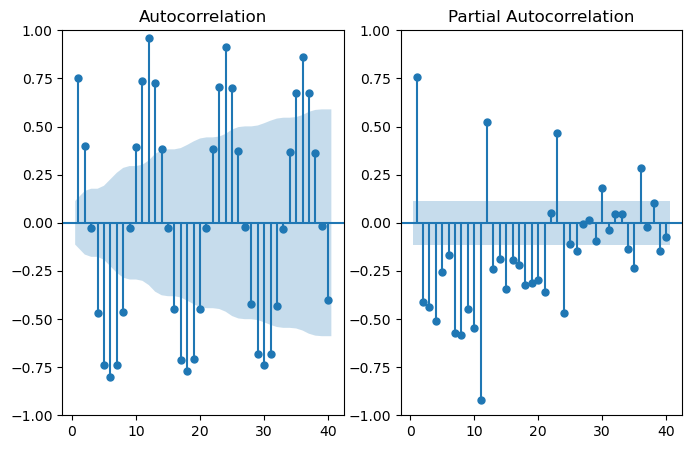

In [48]:
LinearForecast(seasonality_12).plot_acf_pacf({'lags': 40})

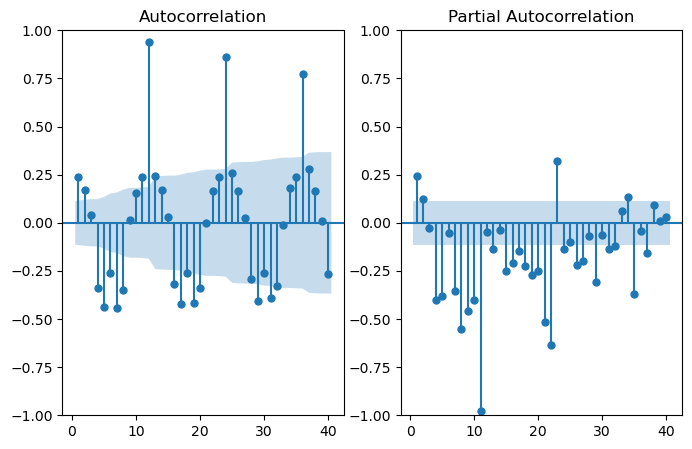

In [49]:
LinearForecast(seasonality_12.diff().dropna()).plot_acf_pacf({'lags': 40})

<Axes: xlabel='date'>

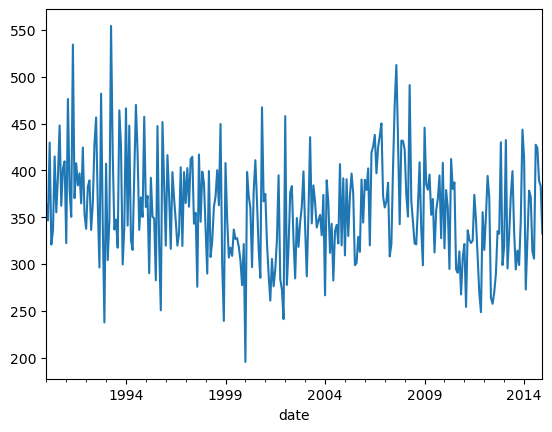

In [52]:
no_Estacion = desco.observed - desco.seasonal['seasonal_12']
no_Estacion.plot()

Código de solución estudiante 2 - Ricardo Damián Hernández Ramírez


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import MSTL
import itertools
from sklearn.preprocessing import power_transform
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Código de solución estudiante 2
class LinearForecast:
    def __init__(self, data):
        self.data = data

    def adf_test(self):
        print("Results of Dickey-Fuller Test:")
        dftest = adfuller(self.data, autolag="AIC")
        dfoutput = pd.Series(
            dftest[0:4],
            index=[
                "Test Statistic",
                "p-value",
                "#Lags Used",
                "Number of Observations Used",
            ],
        )
        for key, value in dftest[4].items():
            dfoutput["Critical Value (%s)" % key] = value
        print(dfoutput)

        if (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0]):
            print("\u001b[32mStationary\u001b[0m")
        else:
            print("\x1b[31mNon-stationary\x1b[0m")

        # Graficar ACF y PACF
    def plot_acf_pacf(self, kwargs=dict()):
        f = plt.figure(figsize=(8,5))

        ax1 = f.add_subplot(121)

        plot_acf(self.data, zero=False, ax=ax1, **kwargs)

        ax2 = f.add_subplot(122)
        plot_pacf(self.data, zero=False, ax=ax2, method='ols', **kwargs)

        plt.show()

    def descomposicion(self):
        data1 = self.data.copy()
        periods_seasonality = (6, 12)

        stl_kwargs = {"seasonal_deg": 0}
        model = MSTL(data1, periods=periods_seasonality, stl_kwargs=stl_kwargs)
        res2 = model.fit()

        # Gráfica de descomposición
        fig, ax = plt.subplots(5, 1, sharex=True, figsize=(8, 8))

        res2.observed.plot(ax=ax[0])
        ax[0].set_ylabel('Observed')

        res2.trend.plot(ax=ax[1])
        ax[1].set_ylabel('Trend')

        res2.seasonal[f'seasonal_{periods_seasonality[0]}'].plot(ax=ax[2])
        ax[2].set_ylabel(f'seasonal_{periods_seasonality[0]}')

        res2.seasonal[f'seasonal_{periods_seasonality[1]}'].plot(ax=ax[3])
        ax[3].set_ylabel(f'seasonal_{periods_seasonality[1]}')

        res2.resid.plot(ax=ax[4])
        ax[4].set_ylabel('Residual')

        fig.tight_layout()

        return res2
    #Combinaciones de parametros
    def sarimaxParameters(self, p, d, q, P, D, Q, chosenSeasonality, t=['n', 'c', 't', 'ct']):

        params_no_estacionales = list(itertools.product(p, d, q))
        params_estacionales = [(x[0], x[1], x[2], chosenSeasonality) for x in list(itertools.product(P, D, Q))]

        # Diferentes combinaciones
        sarimax_params = list(itertools.product(params_no_estacionales, params_estacionales, t))
        self.sarimax_params = sarimax_params

    def findParams(self):

        resultados = pd.DataFrame(columns=['params', 'AIC', 'BIC', 'LLF'], index=np.arange(0, 11))

        print(f'Trying out {len(self.sarimax_params)} posible combinations')

        i = 0
        for par_no_season, par_season, trend in self.sarimax_params:

            mod = SARIMAX(
                endog=self.data,
                trend=trend,
                order=par_no_season,
                seasonal_order=par_season
            )
            results = mod.fit()

            print(f'Model done for params: {par_no_season}, {par_season}, {trend}')

            resultados.loc[i, 'params'] = str((par_no_season, par_season, trend))
            resultados.loc[i, 'AIC'] = results.aic
            resultados.loc[i, 'BIC'] = results.bic
            resultados.loc[i, 'LLF'] = results.llf
            i += 1

        self.resultadosParams = resultados
        return self.resultadosParams
    def sarimax_model(self, order, seasonal_order):
        '''Creates a SARIMAX model with specified order and seasonal_order'''
        model = SARIMAX(self.data, order=order, seasonal_order=seasonal_order)
        return model


    #MAPE
    def calculate_mape(self):

        if not all([isinstance(self.actual, np.ndarray), isinstance(self.predicted, np.ndarray)]):
            self.actual, self.predicted = np.array(self.actual), np.array(self.predicted)

        self.mape =  round(np.mean(np.abs((self.actual - self.predicted) / self.actual)) * 100, 2)

    #MAD
    def calculate_mad(self):

        if not all([isinstance(self.actual, np.ndarray), isinstance(self.predicted, np.ndarray)]):
            self.actual, self.predicted = np.array(self.actual), np.array(self.predicted)

        self.mad =  round(np.mean(np.abs(self.actual - self.predicted)) * 100, 2)

    def errors(self):

        self.calculate_mape()
        self.calculate_mad()
        print(f'MAPE: {self.mape} \n MAD: {self.mad}')


In [ ]:
url = 'https://github.com/quaesito/time-series-forecast-sarimax-prophet/blob/master/A4.xlsx?raw=true'
data = pd.read_excel(url)
data

,Unnamed: 0,date,year,month,day,hour,GHI (W/m2),DNI (W/m2),DHI (W/m2),Wet bulb temp (C),Dew point temp (C),Energy (kWh)
0,6,1990-01-01,1990,Jan,Mon,6,234,503,78,12.1406,9.7,498.632
1,7,1990-01-01,1990,Jan,Mon,7,448,723,91,13.3250,10.1,720.409
2,8,1990-01-01,1990,Jan,Mon,8,699,959,71,13.3094,9.3,946.154
3,9,1990-01-01,1990,Jan,Mon,9,880,1016,73,13.9375,9.1,987.273
4,10,1990-01-01,1990,Jan,Mon,10,1009,1031,85,14.1141,8.0,1000.230
...,...,...,...,...,...,...,...,...,...,...,...,...
96995,8750,2014-12-31,2014,Dec,Wed,14,903,971,94,14.4875,8.8,925.713
96996,8751,2014-12-31,2014,Dec,Wed,15,746,950,76,14.2563,8.8,920.625
96997,8752,2014-12-31,2014,Dec,Wed,16,545,865,69,13.2500,8.6,854.471
96998,8753,2014-12-31,2014,Dec,Wed,17,308,599,80,13.0094,9.0,605.375


In [ ]:
data = data[['date', 'Energy (kWh)']]
data.columns = ['date', 'y']


# Hacer un re muestreo de los datos para que queden de forma mensual (promediarlos)
data = data.set_index('date').resample('M').mean()
data.head()

,y
date,
1990-01-31,451.887005
1990-02-28,423.897505
1990-03-31,430.298776
1990-04-30,296.197605
1990-05-31,288.352006


<Axes: xlabel='date'>

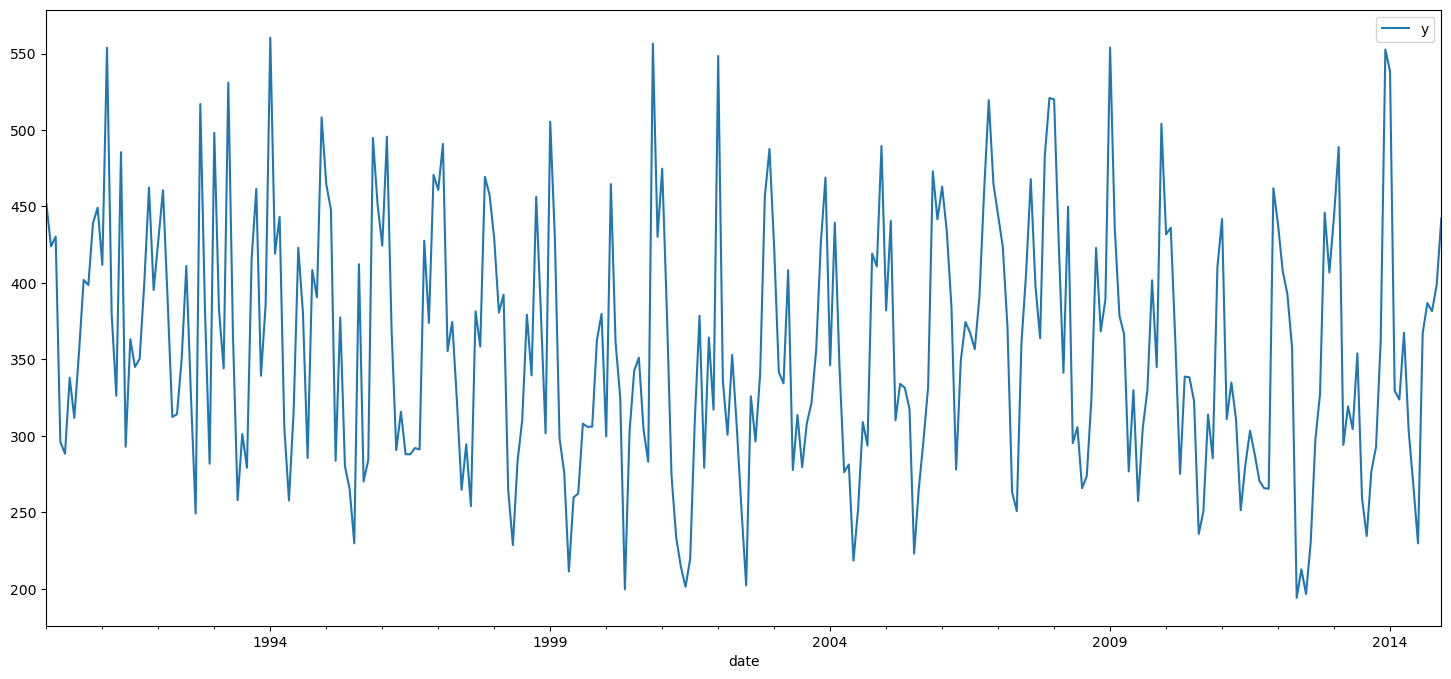

In [ ]:
data.plot(figsize=(18,8))

In [ ]:
model = LinearForecast(data)

In [ ]:
LinearForecast(data).adf_test()


Results of Dickey-Fuller Test:
Test Statistic                  -2.242267
p-value                          0.191264
#Lags Used                      13.000000
Number of Observations Used    286.000000
Critical Value (1%)             -3.453423
Critical Value (5%)             -2.871699
Critical Value (10%)            -2.572183
dtype: float64
Non-stationary


Podemos observar que la serie no es estacionaria, por lo que habrá que diferenciar.

In [ ]:
LinearForecast(data.diff().dropna()).adf_test()


Results of Dickey-Fuller Test:
Test Statistic                -1.185352e+01
p-value                        7.115964e-22
#Lags Used                     1.200000e+01
Number of Observations Used    2.860000e+02
Critical Value (1%)           -3.453423e+00
Critical Value (5%)           -2.871699e+00
Critical Value (10%)          -2.572183e+00
dtype: float64
Stationary


Al hacer una diferenciacion la serie de tiempo se hace estacionaria.

## Descomposición

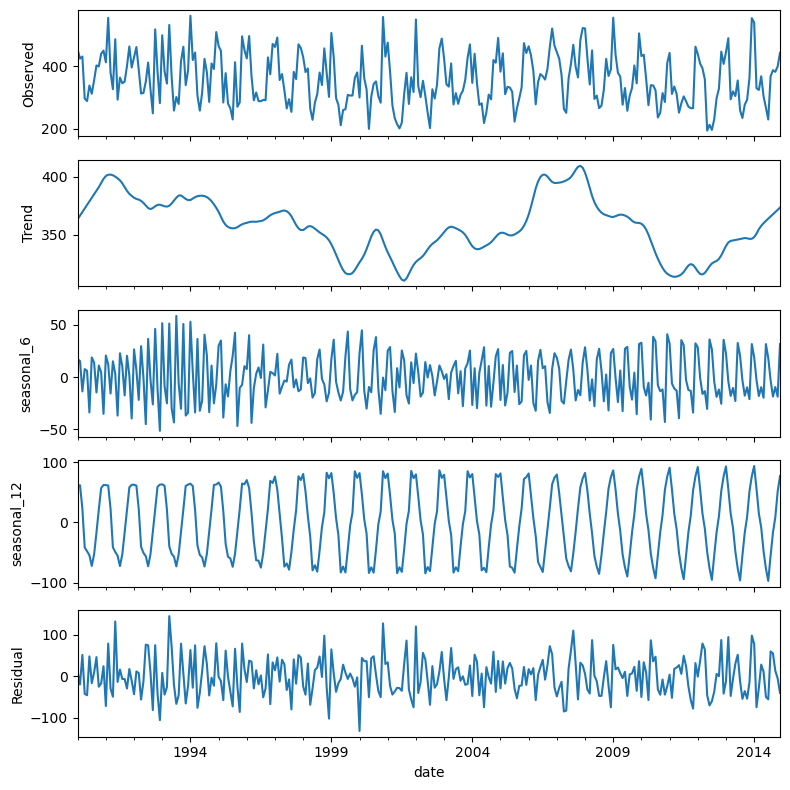

In [ ]:
res = LinearForecast(data).descomposicion()
res

<Axes: xlabel='date'>

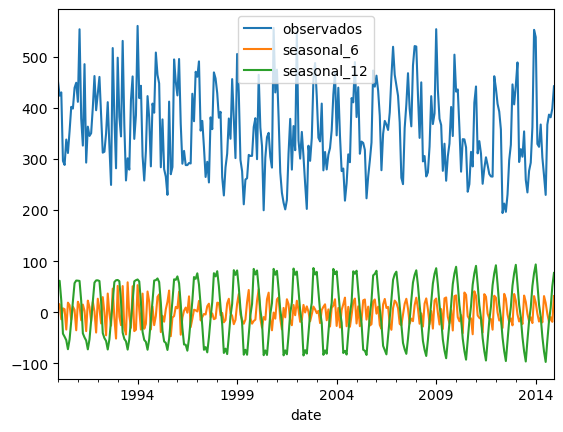

In [ ]:
ax = res.observed.to_frame('observados').plot()
res.seasonal.plot(ax=ax)

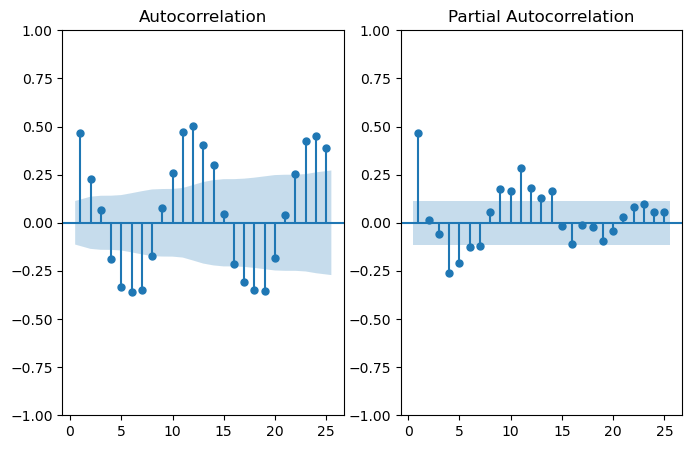

In [ ]:
LinearForecast(data).plot_acf_pacf()


Podemos observar un patrón cada 6 y 12 meses.

In [ ]:
seasonality_6 = res.seasonal['seasonal_6']
LinearForecast(seasonality_6).adf_test()

Results of Dickey-Fuller Test:
Test Statistic                -9.451841e+00
p-value                        4.594080e-16
#Lags Used                     1.600000e+01
Number of Observations Used    2.830000e+02
Critical Value (1%)           -3.453670e+00
Critical Value (5%)           -2.871808e+00
Critical Value (10%)          -2.572241e+00
dtype: float64
Stationary


In [ ]:
seasonality_12 = res.seasonal['seasonal_12']
LinearForecast(seasonality_12).adf_test()

Results of Dickey-Fuller Test:
Test Statistic                 -29.256349
p-value                          0.000000
#Lags Used                      16.000000
Number of Observations Used    283.000000
Critical Value (1%)             -3.453670
Critical Value (5%)             -2.871808
Critical Value (10%)            -2.572241
dtype: float64
Stationary


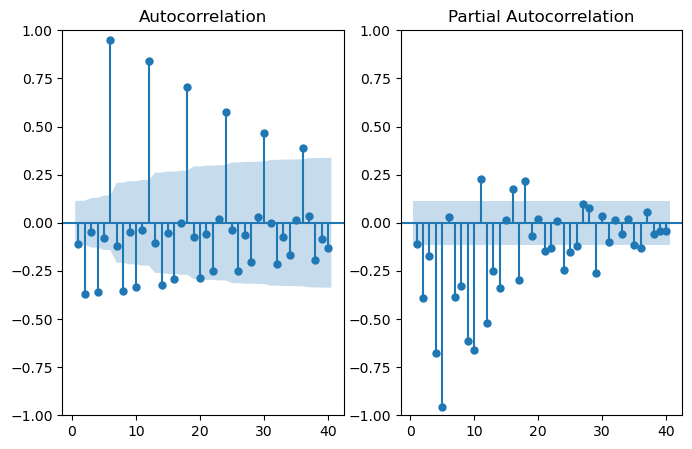

In [ ]:
LinearForecast(seasonality_6).plot_acf_pacf({'lags': 40})


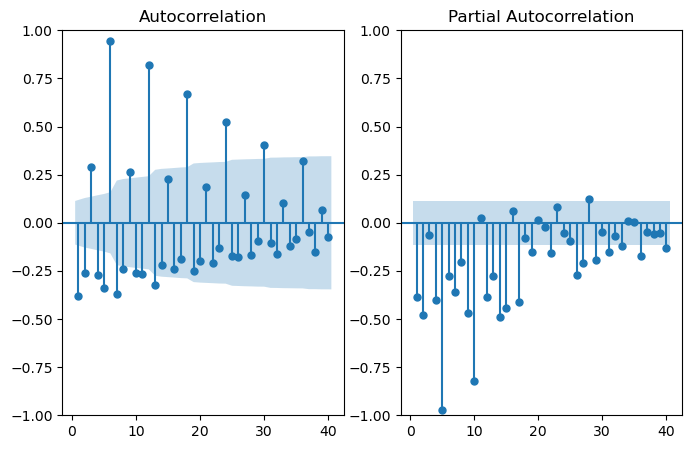

In [ ]:
LinearForecast(seasonality_6.diff().dropna()).plot_acf_pacf({'lags': 40})


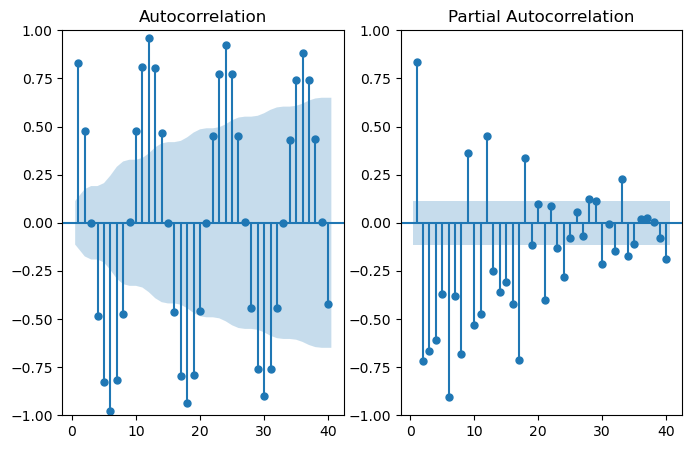

In [ ]:
LinearForecast(seasonality_12).plot_acf_pacf({'lags': 40})


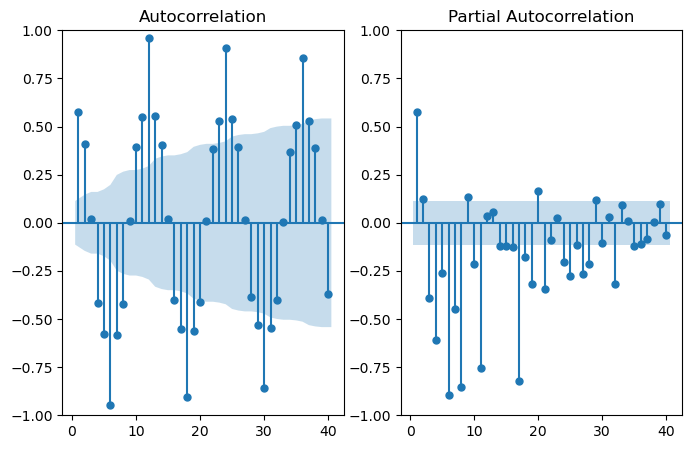

In [ ]:
LinearForecast(seasonality_12.diff().dropna()).plot_acf_pacf({'lags': 40})


Observamos que el componente no estacional no es estacionario, por lo que lo tendremos que diferenciar.

In [ ]:
LinearForecast(res.observed).adf_test()


Results of Dickey-Fuller Test:
Test Statistic                  -2.242267
p-value                          0.191264
#Lags Used                      13.000000
Number of Observations Used    286.000000
Critical Value (1%)             -3.453423
Critical Value (5%)             -2.871699
Critical Value (10%)            -2.572183
dtype: float64
Non-stationary


<Axes: xlabel='date'>

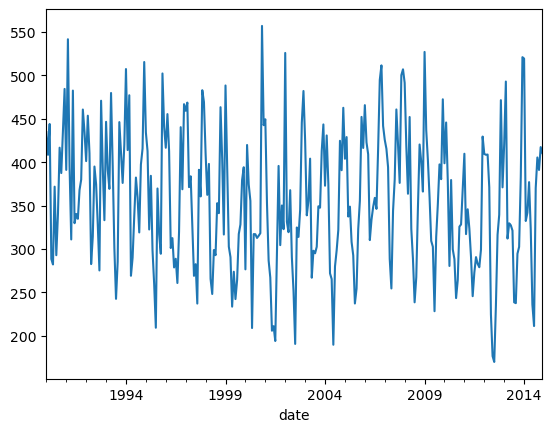

In [ ]:
# Calcular la componente no estacional de la serie temporal
non_seasonal = res.observed - res.seasonal['seasonal_6']
non_seasonal.plot()

In [ ]:
# Calcular si la serie no estacional es estacionaria
LinearForecast(non_seasonal).adf_test()

Results of Dickey-Fuller Test:
Test Statistic                  -2.287739
p-value                          0.175953
#Lags Used                      15.000000
Number of Observations Used    284.000000
Critical Value (1%)             -3.453587
Critical Value (5%)             -2.871771
Critical Value (10%)            -2.572222
dtype: float64
Non-stationary


In [ ]:
LinearForecast(non_seasonal.diff().dropna()).adf_test()

Results of Dickey-Fuller Test:
Test Statistic                  -5.001408
p-value                          0.000022
#Lags Used                      16.000000
Number of Observations Used    282.000000
Critical Value (1%)             -3.453754
Critical Value (5%)             -2.871844
Critical Value (10%)            -2.572261
dtype: float64
Stationary


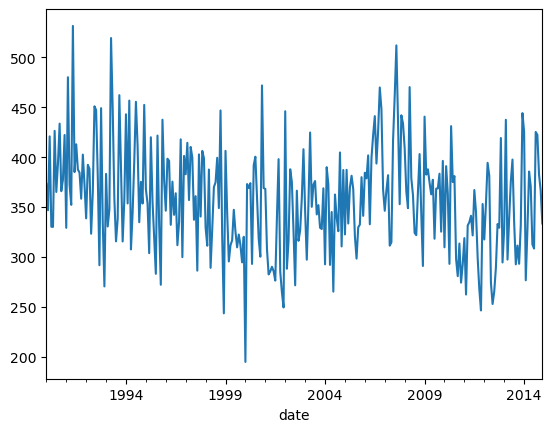

In [ ]:
non_seasonal2 = res.observed - res.seasonal['seasonal_6'] - res.seasonal['seasonal_12']
ax = non_seasonal2.plot()
plt.show()

In [ ]:
# Calcular si la serie no estacional es estacionaria o no
LinearForecast(non_seasonal2).adf_test()

Results of Dickey-Fuller Test:
Test Statistic                  -2.652388
p-value                          0.082646
#Lags Used                      13.000000
Number of Observations Used    286.000000
Critical Value (1%)             -3.453423
Critical Value (5%)             -2.871699
Critical Value (10%)            -2.572183
dtype: float64
Non-stationary


In [ ]:
LinearForecast(non_seasonal2.diff().dropna()).adf_test()

Results of Dickey-Fuller Test:
Test Statistic                -7.982167e+00
p-value                        2.605812e-12
#Lags Used                     1.300000e+01
Number of Observations Used    2.850000e+02
Critical Value (1%)           -3.453505e+00
Critical Value (5%)           -2.871735e+00
Critical Value (10%)          -2.572202e+00
dtype: float64
Stationary


La serie se vuelve estacionaria después de diferenciarla una vez, por eso se usará d=1. Ahora seleccionaré los valores de p y q.

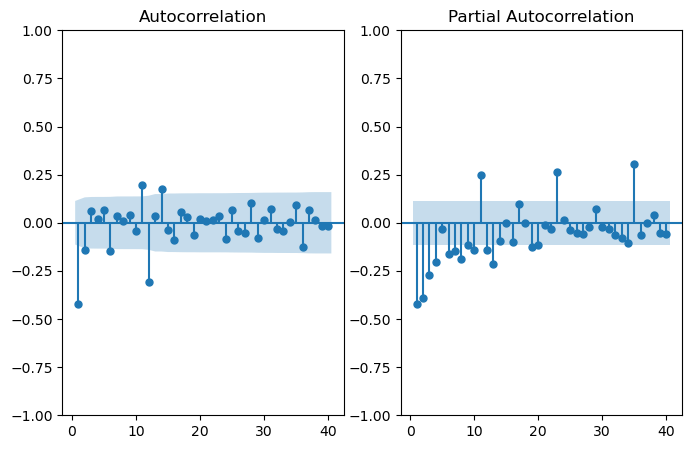

In [ ]:
LinearForecast((non_seasonal2.diff().dropna())).plot_acf_pacf({'lags': 40})

$$ p = 0-2$$, $$q = 0-2$$

In [ ]:
p = [0, 1, 2]
d = [1]
q = [0, 1]
P = [0, 1]
D = [0]
Q = [0, 1]
# Crear una instancia de la clase LinearForecast
forecast = LinearForecast(data)

# Usar el método sarimaxParameters
forecast.sarimaxParameters(p, d, q, P, D, Q, 6)

In [ ]:
posibleParams = forecast.findParams().sort_values(by=['AIC'], ascending=True)
posibleParams

Trying out 96 posible combinations
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.83587D+00    |proj g|=  3.95244D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      3      1     0     0   8.438D-09   5.836D+00
  F =   5.8358657326038266     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Model done for params: (0, 1, 0), (0, 0, 0, 6), n
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =         

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


Model done for params: (0, 1, 0), (0, 0, 1, 6), c
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.83947D+00    |proj g|=  1.00157D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      7      1     0     0   9.410D-06   5.835D+00
  F =   5.8354576756121768     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Model done for params: (0, 1, 0), (0, 0, 1, 6), t
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4  

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


Model done for params: (0, 1, 0), (1, 0, 0, 6), t
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.83531D+00    |proj g|=  4.26551D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      3      5      1     0     0   1.169D-05   5.835D+00
  F =   5.8353056001486809     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Model done for params: (0, 1, 0), (1, 0, 0, 6), ct
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.83434D+00    |proj g|=  2.34353D-02

At iterate   10    f=  5.82503D+00    |proj g|=  4.23637D-02

At iterate   15    f=  5.80469D+00    |proj g|=  5.05192D-03

At iterate   20    f=  5.80010D+00    |proj g|=  2.08326D-04

At iterate   25    f=  5.79939D+00    |proj g|=  2.41314D-04

At iterate   30    f=  5.79923D+00    |proj g|=  9.98273D-05

At iterate   35    f=  5.79920D+00    |proj g|=  4.33808D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     40      1     0     0   5.451D-06   5.799D+00
  F =   5.7991922516880443     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate   10    f=  5.82586D+00    |proj g|=  4.62573D-02

At iterate   15    f=  5.80623D+00    |proj g|=  6.11588D-03

At iterate   20    f=  5.80149D+00    |proj g|=  2.15779D-03

At iterate   25    f=  5.79961D+00    |proj g|=  4.44018D-03

At iterate   30    f=  5.79925D+00    |proj g|=  4.89553D-04

At iterate   35    f=  5.79920D+00    |proj g|=  7.59943D-04

At iterate   40    f=  5.79919D+00    |proj g|=  1.41527D-04

At iterate   45    f=  5.79918D+00    |proj g|=  2.14635D-04

At iterate   50    f=  5.79918D+00    |proj g|=  8.15422D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     60   

 This problem is unconstrained.



At iterate   35    f=  5.79920D+00    |proj g|=  7.06384D-04

At iterate   40    f=  5.79919D+00    |proj g|=  4.54427D-04

At iterate   45    f=  5.79918D+00    |proj g|=  1.54946D-04

At iterate   50    f=  5.79918D+00    |proj g|=  1.82915D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     58      1     0     0   1.829D-05   5.799D+00
  F =   5.7991771380175203     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Model done for params: (0, 1, 0), (1, 0, 1, 6), ct
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0    

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  5.78546D+00    |proj g|=  1.55366D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     22      1     0     0   5.507D-06   5.785D+00
  F =   5.7854547008055306     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Model done for params: (0, 1, 1), (0, 0, 0, 6), c
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.78617D+00    |proj g|=  2.87959D-02

At iterate    5    f=  5.78545D+00    |proj g|=  1.26101D-04

           * * *

T

 This problem is unconstrained.
 This problem is unconstrained.


Model done for params: (0, 1, 1), (0, 0, 1, 6), c
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.79711D+00    |proj g|=  2.39612D-01

At iterate    5    f=  5.76933D+00    |proj g|=  8.62868D-03

At iterate   10    f=  5.76886D+00    |proj g|=  9.63014D-04

At iterate   15    f=  5.76885D+00    |proj g|=  5.57822D-03

At iterate   20    f=  5.74975D+00    |proj g|=  6.51183D-01

At iterate   25    f=  5.74915D+00    |proj g|=  1.78344D-03

At iterate   30    f=  5.74913D+00    |proj g|=  8.52352D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

     

 This problem is unconstrained.



At iterate   20    f=  5.75054D+00    |proj g|=  1.59335D-01

At iterate   25    f=  5.74974D+00    |proj g|=  2.66657D-01

At iterate   30    f=  5.74948D+00    |proj g|=  1.91506D-02

At iterate   35    f=  5.74907D+00    |proj g|=  4.52569D-01

At iterate   40    f=  5.74820D+00    |proj g|=  6.75709D-03

At iterate   45    f=  5.74820D+00    |proj g|=  1.61438D-02

At iterate   50    f=  5.74820D+00    |proj g|=  7.34534D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     66      1     0     0   7.345D-05   5.748D+00
  F =   5.7481961100029411     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.71946D+00    |proj g|=  5.86096D-02

At iterate   10    f=  5.70932D+00    |proj g|=  2.09514D-03

At iterate   15    f=  5.70308D+00    |proj g|=  1.15054D-02

At iterate   20    f=  5.70124D+00    |proj g|=  3.35465D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     24      1     0     0   3.355D-07   5.701D+00
  F =   5.7012419588101713     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Model done for params: (0, 1, 1), (1, 0, 0, 6), n
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0     

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  5.70914D+00    |proj g|=  1.26727D-01

At iterate   15    f=  5.70905D+00    |proj g|=  1.53456D-02

At iterate   20    f=  5.70624D+00    |proj g|=  6.34865D-02

At iterate   25    f=  5.70614D+00    |proj g|=  3.33999D-03

At iterate   30    f=  5.70545D+00    |proj g|=  2.24648D-01

At iterate   35    f=  5.70051D+00    |proj g|=  3.04097D-01

At iterate   40    f=  5.70033D+00    |proj g|=  1.97042D-02

At iterate   45    f=  5.70025D+00    |proj g|=  9.76772D-04

At iterate   50    f=  5.70025D+00    |proj g|=  8.47133D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     62   

 This problem is unconstrained.



At iterate   30    f=  5.52682D+00    |proj g|=  2.58385D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     40      1     0     0   7.803D-06   5.527D+00
  F =   5.5267882133202129     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Model done for params: (0, 1, 1), (1, 0, 1, 6), n
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.79938D+00    |proj g|=  2.72044D-01

At iterate    5    f=  5.63631D+00    |proj g|=  5.20403D-02

At iterate   10    

 This problem is unconstrained.



At iterate   30    f=  5.54608D+00    |proj g|=  8.04132D-04

At iterate   35    f=  5.54598D+00    |proj g|=  2.09188D-04

At iterate   40    f=  5.54596D+00    |proj g|=  4.56248D-04

At iterate   45    f=  5.54595D+00    |proj g|=  1.74515D-04

At iterate   50    f=  5.54595D+00    |proj g|=  2.69676D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     64      1     0     0   2.697D-04   5.546D+00
  F =   5.5459510519861404     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Model done for params: (0, 1, 1), (1, 0, 1, 6), c
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision 

 This problem is unconstrained.



At iterate    5    f=  5.72637D+00    |proj g|=  2.21225D+00

At iterate   10    f=  5.66404D+00    |proj g|=  5.36372D-01

At iterate   15    f=  5.62783D+00    |proj g|=  1.01607D+00

At iterate   20    f=  5.61306D+00    |proj g|=  5.94195D-02

At iterate   25    f=  5.61035D+00    |proj g|=  2.28640D-01

At iterate   30    f=  5.61017D+00    |proj g|=  1.19489D-02

At iterate   35    f=  5.60427D+00    |proj g|=  8.26420D-01

At iterate   40    f=  5.59791D+00    |proj g|=  7.35234D-01

At iterate   45    f=  5.55967D+00    |proj g|=  6.95265D-01

At iterate   50    f=  5.54989D+00    |proj g|=  5.99781D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.72405D+00    |proj g|=  1.22768D+00

At iterate   10    f=  5.65599D+00    |proj g|=  1.96198D+00

At iterate   15    f=  5.62524D+00    |proj g|=  1.74203D+00

At iterate   20    f=  5.60816D+00    |proj g|=  8.56643D-02

At iterate   25    f=  5.60652D+00    |proj g|=  1.26931D-01

At iterate   30    f=  5.60542D+00    |proj g|=  1.63704D-01

At iterate   35    f=  5.60258D+00    |proj g|=  8.06956D-02

At iterate   40    f=  5.59362D+00    |proj g|=  3.27537D-01

At iterate   45    f=  5.54209D+00    |proj g|=  5.19344D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     78   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.80534D+00    |proj g|=  1.94426D-01

At iterate    5    f=  5.79141D+00    |proj g|=  2.10859D-04

At iterate   10    f=  5.79137D+00    |proj g|=  3.72531D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     17      1     0     0   8.350D-06   5.791D+00
  F =   5.7913579222659681     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Model done for params: (1, 1, 0), (0, 0, 1, 6), n
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  5.79138D+00    |proj g|=  1.68951D-03

At iterate   15    f=  5.79135D+00    |proj g|=  6.70777D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     22      1     0     0   1.601D-05   5.791D+00
  F =   5.7913379202416957     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Model done for params: (1, 1, 0), (0, 0, 1, 6), t
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.80522D+00    |proj g|=  1.94364D-01

At iterate    5    

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.78919D+00    |proj g|=  2.32417D-04

At iterate   10    f=  5.78916D+00    |proj g|=  5.29934D-03

At iterate   15    f=  5.78911D+00    |proj g|=  1.08345D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     18      1     0     0   8.439D-07   5.789D+00
  F =   5.7891051476461852     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Model done for params: (1, 1, 0), (1, 0, 0, 6), n
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  5.78909D+00    |proj g|=  2.32259D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     20      1     0     0   9.568D-06   5.789D+00
  F =   5.7890874245034922     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Model done for params: (1, 1, 0), (1, 0, 0, 6), t
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.79345D+00    |proj g|=  8.54923D-02

At iterate    5    f=  5.78910D+00    |proj g|=  2.27547D-04

At iterate   10    

 This problem is unconstrained.



At iterate   10    f=  5.73722D+00    |proj g|=  1.09410D-02

At iterate   15    f=  5.72240D+00    |proj g|=  3.14708D-02

At iterate   20    f=  5.71067D+00    |proj g|=  1.41709D-03

At iterate   25    f=  5.71045D+00    |proj g|=  1.52592D-04

At iterate   30    f=  5.71040D+00    |proj g|=  2.05876D-03

At iterate   35    f=  5.71038D+00    |proj g|=  8.71544D-05

At iterate   40    f=  5.71037D+00    |proj g|=  5.16948D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     43     54      1     0     0   1.595D-05   5.710D+00
  F =   5.7103677665406973     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  5.78432D+00    |proj g|=  3.21222D-02

At iterate   10    f=  5.73722D+00    |proj g|=  1.09412D-02

At iterate   15    f=  5.72240D+00    |proj g|=  3.14685D-02

At iterate   20    f=  5.71067D+00    |proj g|=  1.41664D-03

At iterate   25    f=  5.71045D+00    |proj g|=  1.62373D-04

At iterate   30    f=  5.71040D+00    |proj g|=  1.97444D-03

At iterate   35    f=  5.71038D+00    |proj g|=  3.72641D-04

At iterate   40    f=  5.71037D+00    |proj g|=  8.47793D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     48      1     0     0   8.478D-06   5.710D+00
  F =   5.71036949329

 This problem is unconstrained.



At iterate   40    f=  5.71040D+00    |proj g|=  8.73319D-04

At iterate   45    f=  5.71038D+00    |proj g|=  5.40248D-04

At iterate   50    f=  5.71037D+00    |proj g|=  3.10722D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     55      1     0     0   3.107D-04   5.710D+00
  F =   5.7103683604865516     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Model done for params: (1, 1, 0), (1, 0, 1, 6), t
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  5.71044D+00    |proj g|=  1.89068D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     31      1     0     0   1.099D-05   5.710D+00
  F =   5.7103892762377289     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Model done for params: (1, 1, 0), (1, 0, 1, 6), ct
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.78378D+00    |proj g|=  3.40387D-02

At iterate    5    f=  5.76988D+00    |proj g|=  1.03976D-01

At iterate   10   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  5.68929D+00    |proj g|=  3.04057D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     26      1     0     0   1.728D-06   5.689D+00
  F =   5.6892887212453465     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Model done for params: (1, 1, 1), (0, 0, 0, 6), c
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.78376D+00    |proj g|=  3.39753D-02

At iterate    5    f=  5.76621D+00    |proj g|=  1.50519D+00

At iterate   10    


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.78371D+00    |proj g|=  3.40401D-02

At iterate    5    f=  5.76579D+00    |proj g|=  1.56656D+00

At iterate   10    f=  5.72215D+00    |proj g|=  4.38265D-01

At iterate   15    f=  5.70251D+00    |proj g|=  1.42500D+00

At iterate   20    f=  5.70070D+00    |proj g|=  5.56176D-02

At iterate   25    f=  5.70060D+00    |proj g|=  3.69377D-02

At iterate   30    f=  5.70053D+00    |proj g|=  4.90231D-01

At iterate   35    f=  5.69641D+00    |proj g|=  6.27289D-01

At iterate   40    f=  5.69367D+00    |proj g|=  5.01557D+00

At iterate   45    f=  5.68799D+00    |proj g|=  1.13468D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  5.69600D+00    |proj g|=  3.00200D-02

At iterate   15    f=  5.69204D+00    |proj g|=  1.10629D-02

At iterate   20    f=  5.68032D+00    |proj g|=  1.12324D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     32      1     0     0   1.229D-06   5.680D+00
  F =   5.6802055675766789     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Model done for params: (1, 1, 1), (0, 0, 1, 6), c
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    

 This problem is unconstrained.



At iterate   15    f=  5.69682D+00    |proj g|=  2.92106D-01

At iterate   20    f=  5.69400D+00    |proj g|=  3.27473D-01

At iterate   25    f=  5.69366D+00    |proj g|=  2.90731D-01

At iterate   30    f=  5.68651D+00    |proj g|=  1.81202D+01

At iterate   35    f=  5.68153D+00    |proj g|=  1.89586D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     65      1     0     0   6.470D-03   5.682D+00
  F =   5.6815165346053620     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Model done for params: (1, 1, 1), (0, 0, 1, 6), t
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.79502D+00    |proj g|=  2.46497D-01

At iterate    5    f=  5.76707D+00    |proj g|=  2.73784D-02

At iterate   10    f=  5.72326D+00    |proj g|=  5.27495D-01

At iterate   15    

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  5.68795D+00    |proj g|=  9.70022D-03

At iterate   15    f=  5.68183D+00    |proj g|=  2.10636D-02

At iterate   20    f=  5.67405D+00    |proj g|=  1.26243D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     31      1     0     0   6.789D-06   5.674D+00
  F =   5.6740493896163846     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Model done for params: (1, 1, 1), (1, 0, 0, 6), c
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    

 This problem is unconstrained.



At iterate   10    f=  5.70222D+00    |proj g|=  1.96188D+00

At iterate   15    f=  5.68926D+00    |proj g|=  6.24339D-02

At iterate   20    f=  5.68830D+00    |proj g|=  3.38132D-01

At iterate   25    f=  5.68827D+00    |proj g|=  2.41289D-02

At iterate   30    f=  5.68821D+00    |proj g|=  2.21759D-01

At iterate   35    f=  5.68464D+00    |proj g|=  4.68257D-01

At iterate   40    f=  5.67532D+00    |proj g|=  8.62857D-03

At iterate   45    f=  5.67522D+00    |proj g|=  3.40042D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     47     57      1     0     0   6.789D-03   5.675D+00
  F =   5.67521624432

 This problem is unconstrained.



At iterate   30    f=  5.68608D+00    |proj g|=  1.00057D+00

At iterate   35    f=  5.67319D+00    |proj g|=  1.88831D+00

At iterate   40    f=  5.67252D+00    |proj g|=  1.64051D-02

At iterate   45    f=  5.67251D+00    |proj g|=  2.80558D-01

At iterate   50    f=  5.67217D+00    |proj g|=  1.51293D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     57      1     0     0   1.513D+00   5.672D+00
  F =   5.6721658716083843     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Model done for params: (1, 1, 1), (1, 0, 0, 6), ct
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision

 This problem is unconstrained.



At iterate   10    f=  5.61056D+00    |proj g|=  1.03872D-02

At iterate   15    f=  5.57605D+00    |proj g|=  1.15541D-02

At iterate   20    f=  5.54493D+00    |proj g|=  2.75939D-03

At iterate   25    f=  5.54492D+00    |proj g|=  5.08944D-04

At iterate   30    f=  5.54486D+00    |proj g|=  4.94299D-03

At iterate   35    f=  5.54464D+00    |proj g|=  4.00476D-04

At iterate   40    f=  5.54459D+00    |proj g|=  1.31877D-03

At iterate   45    f=  5.54457D+00    |proj g|=  3.21929D-04

At iterate   50    f=  5.54456D+00    |proj g|=  7.73728D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     61   

 This problem is unconstrained.



At iterate   15    f=  5.58501D+00    |proj g|=  4.55115D-02

At iterate   20    f=  5.53692D+00    |proj g|=  2.15949D-02

At iterate   25    f=  5.53635D+00    |proj g|=  4.59998D-05

At iterate   30    f=  5.53634D+00    |proj g|=  2.13942D-03

At iterate   35    f=  5.53617D+00    |proj g|=  6.21002D-03

At iterate   40    f=  5.53611D+00    |proj g|=  9.03643D-04

At iterate   45    f=  5.53601D+00    |proj g|=  1.64226D-03

At iterate   50    f=  5.53599D+00    |proj g|=  8.41190D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     54      1     0     0   8.412D-04   5.536D+00
  F =   5.53598794866

 This problem is unconstrained.



At iterate   25    f=  5.60482D+00    |proj g|=  3.17779D-01

At iterate   30    f=  5.59952D+00    |proj g|=  2.27618D-01

At iterate   35    f=  5.56711D+00    |proj g|=  1.69192D-01

At iterate   40    f=  5.54114D+00    |proj g|=  2.28706D+00

At iterate   45    f=  5.53890D+00    |proj g|=  2.25082D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45     53      1     0     0   2.251D-03   5.539D+00
  F =   5.5388950741310978     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Model done for params: (1, 1, 1), (1, 0, 1, 6), t
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision 

 This problem is unconstrained.



At iterate    5    f=  5.75163D+00    |proj g|=  5.08786D-02

At iterate   10    f=  5.68544D+00    |proj g|=  1.59308D+00

At iterate   15    f=  5.61926D+00    |proj g|=  1.03097D-01

At iterate   20    f=  5.60251D+00    |proj g|=  4.88035D-01

At iterate   25    f=  5.60162D+00    |proj g|=  2.54510D-01

At iterate   30    f=  5.59984D+00    |proj g|=  1.03260D+00

At iterate   35    f=  5.59733D+00    |proj g|=  3.73339D-01

At iterate   40    f=  5.59682D+00    |proj g|=  1.07689D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f=  5.59394D+00    |proj g|=  9.99709D-01

At iterate   50    f=  5.59387D+00    |proj g|=  2.78180D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     84      2     0     0   2.782D-02   5.594D+00
  F =   5.5938676558684692     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Model done for params: (1, 1, 1), (1, 0, 1, 6), ct
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.78373D+00    |proj g|=  1.00311D-03

           * * *



 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


Model done for params: (2, 1, 0), (0, 0, 0, 6), ct
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.79604D+00    |proj g|=  2.65452D-01

At iterate    5    f=  5.76968D+00    |proj g|=  4.36053D-04

At iterate   10    f=  5.76965D+00    |proj g|=  4.94076D-03

At iterate   15    f=  5.76938D+00    |proj g|=  3.73265D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     20      1     0     0   9.705D-06   5.769D+00
  F =   5.7693667720270829     

CONVERGENCE: NORM_

 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.79601D+00    |proj g|=  2.65422D-01

At iterate    5    f=  5.76967D+00    |proj g|=  4.16617D-03

At iterate   10    f=  5.76966D+00    |proj g|=  1.67500D-03

At iterate   15    f=  5.76951D+00    |proj g|=  1.72990D-02

At iterate   20    f=  5.76934D+00    |proj g|=  1.66533D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     26      1     0     0   5.658D-07   5.769D+00
  F =   5.7693439308941992     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL    

 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  5.75985D+00    |proj g|=  6.94613D-04

At iterate   10    f=  5.75964D+00    |proj g|=  1.30179D-02

At iterate   15    f=  5.75903D+00    |proj g|=  3.40854D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     19      1     0     0   8.303D-05   5.759D+00
  F =   5.7590322340346294     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Model done for params: (2, 1, 0), (1, 0, 0, 6), c
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  5.75902D+00    |proj g|=  1.61173D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     24      1     0     0   8.800D-06   5.759D+00
  F =   5.7590173730319005     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Model done for params: (2, 1, 0), (1, 0, 0, 6), t
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.77835D+00    |proj g|=  1.50256D-01

At iterate    5    f=  5.75972D+00    |proj g|=  7.01451D-04

At iterate   10    

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.73802D+00    |proj g|=  7.66114D-02

At iterate   10    f=  5.67163D+00    |proj g|=  1.68024D-02

At iterate   15    f=  5.65878D+00    |proj g|=  9.02217D-03

At iterate   20    f=  5.63561D+00    |proj g|=  1.84144D-02

At iterate   25    f=  5.63075D+00    |proj g|=  3.98331D-04

At iterate   30    f=  5.63075D+00    |proj g|=  6.89641D-04

At iterate   35    f=  5.63075D+00    |proj g|=  8.29247D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     40      1     0     0   1.548D-05   5.631D+00
  F =   5.6307498593428864     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   30    f=  5.63072D+00    |proj g|=  1.17616D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     36      1     0     0   3.367D-06   5.631D+00
  F =   5.6307232003990633     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Model done for params: (2, 1, 0), (1, 0, 1, 6), t
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.79831D+00    |proj g|=  3.00288D-01

At iterate    5    f=  5.75228D+00    |proj g|=  5.68471D-02

At iterate   10    

 This problem is unconstrained.



At iterate   20    f=  5.65243D+00    |proj g|=  3.21044D-02

At iterate   25    f=  5.63596D+00    |proj g|=  6.96040D-03

At iterate   30    f=  5.63072D+00    |proj g|=  9.75637D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     34     38      1     0     0   1.046D-05   5.631D+00
  F =   5.6307137743990250     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Model done for params: (2, 1, 0), (1, 0, 1, 6), ct
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  5.78307D+00    |proj g|=  3.27484D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   3.275D-05   5.783D+00
  F =   5.7830718286968654     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Model done for params: (2, 1, 1), (0, 0, 0, 6), n
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.78316D+00    |proj g|=  2.62386D-03

At iterate    5    f=  5.78311D+00    |proj g|=  3.74206D-03

At iterate   10    

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.78310D+00    |proj g|=  3.63146D-03

At iterate   10    f=  5.78305D+00    |proj g|=  1.54612D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     15      1     0     0   3.285D-05   5.783D+00
  F =   5.7830458846028687     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Model done for params: (2, 1, 1), (0, 0, 0, 6), t
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.78310D+00    |proj g|=  2.59986D-03

At iterate    5    

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.76935D+00    |proj g|=  2.94377D-03

At iterate   10    f=  5.76934D+00    |proj g|=  1.40362D-03

At iterate   15    f=  5.76931D+00    |proj g|=  2.20681D-03

At iterate   20    f=  5.76912D+00    |proj g|=  7.69380D-03

At iterate   25    f=  5.76910D+00    |proj g|=  1.63555D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     28      1     0     0   1.636D-05   5.769D+00
  F =   5.7691006367852120     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Model done for params: (2, 1, 1), (0, 0, 1, 6), t
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision 

 This problem is unconstrained.



At iterate    5    f=  5.76932D+00    |proj g|=  2.95294D-03

At iterate   10    f=  5.76932D+00    |proj g|=  1.46185D-03

At iterate   15    f=  5.76928D+00    |proj g|=  2.19685D-03

At iterate   20    f=  5.76908D+00    |proj g|=  8.40629D-03

At iterate   25    f=  5.76905D+00    |proj g|=  7.49167D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     25     28      1     0     0   7.492D-05   5.769D+00
  F =   5.7690516004533663     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Model done for params: (2, 1, 1), (0, 0, 1, 6), ct
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision

 This problem is unconstrained.



At iterate    5    f=  5.76024D+00    |proj g|=  4.34697D-03

At iterate   10    f=  5.73644D+00    |proj g|=  9.96033D-02

At iterate   15    f=  5.68780D+00    |proj g|=  1.53419D-02

At iterate   20    f=  5.68502D+00    |proj g|=  1.12663D-02

At iterate   25    f=  5.67765D+00    |proj g|=  3.91641D-03

At iterate   30    f=  5.67763D+00    |proj g|=  8.74563D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     38      1     0     0   8.746D-06   5.678D+00
  F =   5.6776298560902330     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Model done for params: (2, 1, 1), (1, 0, 0, 6), n


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.77793D+00    |proj g|=  1.49531D-01

At iterate    5    f=  5.76027D+00    |proj g|=  4.32732D-03

At iterate   10    f=  5.73674D+00    |proj g|=  9.93190D-02

At iterate   15    f=  5.69102D+00    |proj g|=  1.29155D-02

At iterate   20    f=  5.68482D+00    |proj g|=  4.83372D-03

At iterate   25    f=  5.67928D+00    |proj g|=  4.29979D-02

At iterate   30    f=  5.67348D+00    |proj g|=  2.16868D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate   15    f=  5.71877D+00    |proj g|=  7.53358D-01

At iterate   20    f=  5.69441D+00    |proj g|=  1.76048D-01

At iterate   25    f=  5.68639D+00    |proj g|=  2.63325D-01

At iterate   30    f=  5.68582D+00    |proj g|=  1.27230D-01

At iterate   35    f=  5.68567D+00    |proj g|=  4.37321D-01

At iterate   40    f=  5.67780D+00    |proj g|=  2.91087D+00

At iterate   45    f=  5.67606D+00    |proj g|=  1.91763D+00

At iterate   50    f=  5.67503D+00    |proj g|=  1.93767D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     60      1     0     0   1.938D-03   5.675D+00
  F =   5.67503280947

 This problem is unconstrained.



At iterate   15    f=  5.72256D+00    |proj g|=  5.97224D-01

At iterate   20    f=  5.69361D+00    |proj g|=  8.70582D-01

At iterate   25    f=  5.68501D+00    |proj g|=  7.22588D-02

At iterate   30    f=  5.68331D+00    |proj g|=  6.44702D-01

At iterate   35    f=  5.68278D+00    |proj g|=  8.42952D-02

At iterate   40    f=  5.68190D+00    |proj g|=  6.46796D-01

At iterate   45    f=  5.68081D+00    |proj g|=  3.18331D-02

At iterate   50    f=  5.68065D+00    |proj g|=  2.22103D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     61      1     0     0   2.221D-01   5.681D+00
  F =   5.68065038862

 This problem is unconstrained.



At iterate   15    f=  5.58894D+00    |proj g|=  1.08317D-02

At iterate   20    f=  5.56880D+00    |proj g|=  2.98670D-02

At iterate   25    f=  5.54201D+00    |proj g|=  5.31752D-03

At iterate   30    f=  5.54142D+00    |proj g|=  1.22629D-02

At iterate   35    f=  5.52052D+00    |proj g|=  3.52361D-02

At iterate   40    f=  5.51965D+00    |proj g|=  1.20486D-04

At iterate   45    f=  5.51965D+00    |proj g|=  7.76877D-04

At iterate   50    f=  5.51957D+00    |proj g|=  8.15594D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     64      1     0     0   8.156D-03   5.520D+00
  F =   5.51957082270

 This problem is unconstrained.



At iterate   10    f=  5.61412D+00    |proj g|=  1.07195D-01

At iterate   15    f=  5.58987D+00    |proj g|=  1.10378D-02

At iterate   20    f=  5.57822D+00    |proj g|=  8.88581D-03

At iterate   25    f=  5.53017D+00    |proj g|=  1.20847D-02

At iterate   30    f=  5.51925D+00    |proj g|=  1.93139D-03

At iterate   35    f=  5.51922D+00    |proj g|=  2.99093D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     35     38      1     0     0   2.991D-05   5.519D+00
  F =   5.5192240466536910     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Model done for params: (2, 1, 1), (1, 0, 1, 6), c
R

 This problem is unconstrained.



At iterate   25    f=  5.58795D+00    |proj g|=  4.79062D-02

At iterate   30    f=  5.58791D+00    |proj g|=  2.67564D-02

At iterate   35    f=  5.58750D+00    |proj g|=  6.85898D-02

At iterate   40    f=  5.57327D+00    |proj g|=  1.11727D-01

At iterate   45    f=  5.52025D+00    |proj g|=  7.02473D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     49     57      1     0     0   2.130D-03   5.520D+00
  F =   5.5201941658157887     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Model done for params: (2, 1, 1), (1, 0, 1, 6), t
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision 

 This problem is unconstrained.



At iterate   20    f=  5.60069D+00    |proj g|=  9.07089D-02

At iterate   25    f=  5.58762D+00    |proj g|=  5.97767D-02

At iterate   30    f=  5.58757D+00    |proj g|=  3.52943D-02

At iterate   35    f=  5.58717D+00    |proj g|=  5.76517D-02

At iterate   40    f=  5.58553D+00    |proj g|=  1.21688D-01

At iterate   45    f=  5.56296D+00    |proj g|=  1.09586D+00

At iterate   50    f=  5.52960D+00    |proj g|=  2.67285D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     60      1     0     0   2.673D-01   5.530D+00
  F =   5.5296042303714552     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

,params,AIC,BIC,LLF
92,"((2, 1, 1), (1, 0, 1, 6), 'n')",3323.742494,3345.945155,-1655.871247
28,"((0, 1, 1), (1, 0, 1, 6), 'n')",3324.072928,3338.874702,-1658.036464
93,"((2, 1, 1), (1, 0, 1, 6), 'c')",3325.534428,3351.437533,-1655.767214
94,"((2, 1, 1), (1, 0, 1, 6), 't')",3326.116499,3352.019605,-1656.05825
61,"((1, 1, 1), (1, 0, 1, 6), 'c')",3333.592769,3355.795431,-1660.796385
...,...,...,...,...
6,"((0, 1, 0), (0, 0, 1, 6), 't')",3507.274605,3518.375936,-1750.637303
5,"((0, 1, 0), (0, 0, 1, 6), 'c')",3507.284056,3518.385387,-1750.642028
3,"((0, 1, 0), (0, 0, 0, 6), 'ct')",3507.474469,3518.575799,-1750.737234
11,"((0, 1, 0), (1, 0, 0, 6), 'ct')",3509.18336,3523.985134,-1750.59168


In [ ]:
order = (2, 1, 1)
seasonal_order = (1, 0, 1, 6)

# Crear una instancia de la clase LinearForecast
forecast = LinearForecast(data)  # 'data' es tu serie de tiempo

# Llamar a la función sarimax_model en la instancia de la clase LinearForecast
model = forecast.sarimax_model(order, seasonal_order)

# Ajustar el modelo a tus datos
results = model.fit()

# Ver un resumen del modelo ajustado
print(results.summary())


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.79774D+00    |proj g|=  2.98063D-01

At iterate    5    f=  5.74817D+00    |proj g|=  5.14454D-02

At iterate   10    f=  5.61383D+00    |proj g|=  1.07684D-01

At iterate   15    f=  5.58894D+00    |proj g|=  1.08317D-02

At iterate   20    f=  5.56880D+00    |proj g|=  2.98670D-02

At iterate   25    f=  5.54201D+00    |proj g|=  5.31752D-03


 This problem is unconstrained.



At iterate   30    f=  5.54142D+00    |proj g|=  1.22629D-02

At iterate   35    f=  5.52052D+00    |proj g|=  3.52361D-02

At iterate   40    f=  5.51965D+00    |proj g|=  1.20486D-04

At iterate   45    f=  5.51965D+00    |proj g|=  7.76877D-04

At iterate   50    f=  5.51957D+00    |proj g|=  8.15594D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     64      1     0     0   8.156D-03   5.520D+00
  F =   5.5195708227017315     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                                     SARIMAX Results                                     
Dep. Variable:         

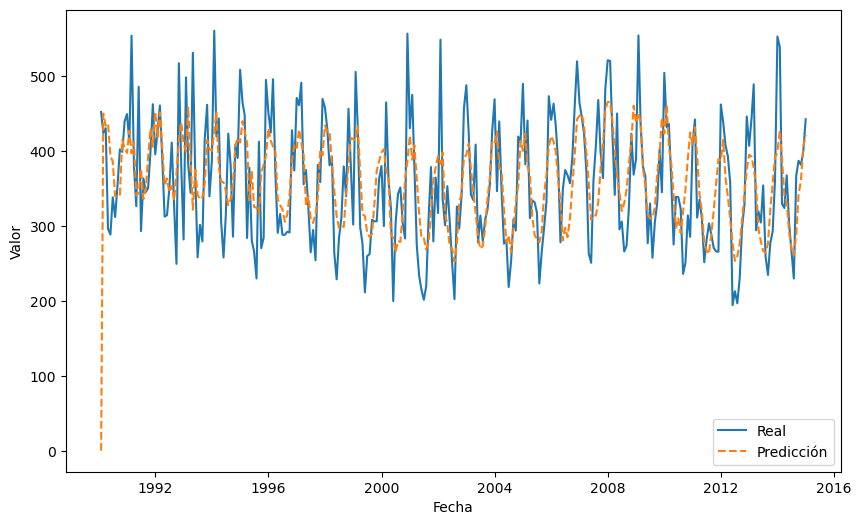

In [ ]:

# Obtener las predicciones del modelo ajustado
predictions = results.predict()

# Graficar la serie de tiempo real y la serie de tiempo predicha
plt.figure(figsize=(10, 6))
plt.plot(data, label='Real')
plt.plot(predictions, label='Predicción', linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()